<h1>Income Inequality prediction</h1>

## 🧾Description
The Problem of income being distributed in an **uneven** manner among a population is a growing problem in developing nations across the world.

With the rapid rise of **AI** and **worker automation**, this problem could continue to grow if steps are not taken to address the issue.

### Objective: 
This project is an effort to create a **machine learning** model that predict whether an individual earns above or below a certain amount based on  **key population indicators** that effect the income level, which can help policymakers to better manage and avoid income inequality globally.

The target feature is `income_above_limit` which is a **Binary-class** variable.

The metric used for evaluation is `f1-score`.

---

## 📚Loading necessary libraries
- **NumPy**: A library for numerical operations in Python.
- **Pandas**: A powerful library for data manipulation and analysis.
- **Matplotlib**: A library for creating static, interactive, and animated visualizations in Python.
- **Seaborn**: A data visualization library based on Matplotlib for making attractive and informative statistical graphics.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Checking the version of the library installed in the Environment. 
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

# Matplotlib plots appear directly within the notebook, enhancing the interactivity
%matplotlib inline

# Dark visual theme and 'pastel' color palette for Seaborn plots.
sns.set_theme(style="dark")
sns.set_palette("pastel")


# Suppresssing non-critical warnings to maintain clean and uncluttered output for better readability.
import warnings
warnings.filterwarnings('ignore')

# Display all columns without truncation
pd.set_option('display.max_columns', None)

Numpy version: 1.25.2
Pandas version: 2.1.0
Matplotlib version: 3.7.2
Seaborn version: 0.12.2


## 🛠️Function Definations

In [1]:
# Function to count all the values with leading or trailing Whitespaces in categorical columns.
def count_leading_and_trailing_whitespaces(dataframe):

    leading_whitespace_count = 0
    trailing_whitespace_count = 0
    having_both = 0

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            leading_whitespace_count += (dataframe[column].str.startswith(' ').sum())
            trailing_whitespace_count += (dataframe[column].str.endswith(' ').sum())
            having_both += ((dataframe[column].str.startswith(' ')) & (dataframe[column].str.endswith(' '))).sum()

    result = leading_whitespace_count + trailing_whitespace_count - having_both
    print("No of values in the dataframe that have a leading or trailing whitespaces or both: ", result)



# Function prints the number of columns in a DataFrame and lists their names in square brackets, separated by commas. 
def columns_in_a_dataframe(dataframe):

    dataframe_columns = dataframe.columns.tolist()
    print(f"Number of columns: {len(dataframe_columns)}")
    print(f"{dataframe_columns}\n")


# Function distinguishes columns in a DataFrame based on their data types
def distinguish_column_ac_to_datatype(dataframe):
    data_types = {
        'Numerical': ['number'],
        'Categorical': ['category', 'object'],
        'Datetime': ['datetime', 'datetime64[ns]']
    }
    
    for dtype, dtype_list in data_types.items():
        columns = dataframe.select_dtypes(include=dtype_list).columns.tolist()
        if columns:
            print(f"Number of {dtype} columns: {len(columns)}")
            print(f"{columns}\n")
        else:
            print(f"No {dtype} column in your dataframe")


# Function prints the number of missing value and percentage of missing values for each column having atleast one missing value
def missing_values_table(dataframe):
        
    mis_val = dataframe.isnull().sum()
    mis_val_percent = 100 * mis_val / len(dataframe)
        
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(dataframe.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns


# Function prints unique values for each column when unique values in that column is less than or equal to max_unique_values.
def unique_values_per_column(dataframe, max_unique_values):
    for column in dataframe.columns:
        unique_values = dataframe[column].unique()
        
        if len(unique_values) <= max_unique_values:
            print(f"Column: {column}")
            print(f"Number of Unique values: {len(unique_values)}")
            print(f"Unique values: {', '.join(map(str, unique_values))}\n")


# Function giving value count for each unique value sorted in descending order of occurance of each unique value
def unique_value_with_count(dataframe):
    for column in dataframe.columns:
        print(f"Column: {dataframe[column].value_counts().sort_values(ascending=False)}")
        print("\n")


# Function plots histograms and boxplots for numerical columns in a DataFrame
def plot_numerical_histogram_boxplot(dataframe):
    numerical_columns = dataframe.select_dtypes(include=['number'])
    
    for column in numerical_columns.columns:
        plt.figure(figsize=(15,6))

        axes = plt.subplot(1,2,1)
        ax = sns.histplot(dataframe, x = column, bins = 20, edgecolor = 'black', color='#AEC6CF')

        ax.patch.set_edgecolor('black')
        ax.patch.set_linewidth(2)
        
        axes.set_xlabel(column)
        axes.set_ylabel('frequency')
        axes.set_title(f'Histogram of {column}')

        axes = plt.subplot(1,2,2)
        axbox = sns.boxplot(dataframe, y= column,  color='#FFC0CB')

        axbox.patch.set_edgecolor('black')
        axbox.patch.set_linewidth(2)

        axes.set_ylabel(column)
        axes.set_title(f'Boxplot of {column}')

        # Adjust layout
        plt.tight_layout()
        plt.show()


# Function to plot countplots of all categorical variables in an ascending order of count of each unique variable with unique values less than or equal to the argument unique_value_limit 
def plot_categorical_countplots(dataframe, unique_value_limit=10):
    categorical_columns = dataframe.select_dtypes(include=['object'])

    for column in categorical_columns.columns:
        unique_count = len(dataframe[column].unique())
        if unique_count <= unique_value_limit:
            plt.figure(figsize=(15, 6))
            ax = sns.countplot(data=dataframe, x=column, edgecolor= 'black' ,order= dataframe[column].value_counts(ascending=True).index)

            ax.patch.set_edgecolor('black')
            ax.patch.set_linewidth(2)
            
            plt.xticks(rotation=90)
            plt.title(f'Countplot of {column}')
            plt.xlabel('')

            total_count = len(dataframe[column])
            
            # Add text annotations for the count at the top and percentage in the middle of each bar
            for p in ax.patches:
                height = p.get_height()
                height = int(height)
                percentage = (height / total_count) * 100
                x = p.get_x() + p.get_width() / 2.

                if percentage < 5:
                    y_top_percentage = height + 10
                    ax.annotate(f'{percentage:.2f}%',
                            (x, y_top_percentage),
                            ha='center', va='bottom', fontsize=12, color='black')
                else:
                    y_top = height + 10
                    ax.annotate(f'{height}',
                            (x, y_top),
                            ha='center', va='bottom', fontsize=12, color='black')
                    y_middle = height / 2
                    ax.annotate(f'{percentage:.2f}%',
                            (x, y_middle),
                            ha='center', va='center', fontsize=12, color='black')
            plt.show()


# Function to plot countplot of categorical variable in an ascending order of count of each unique variable
def plot_single_categorical_countplot(dataframe, column_name):
    if column_name not in dataframe.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return

    unique_count = len(dataframe[column_name].unique())

    if unique_count <= 20:
        plt.figure(figsize=(15, 6))
        ax = sns.countplot(data=dataframe, x=column_name, edgecolor='black', order=dataframe[column_name].value_counts(ascending=False).index)

        ax.patch.set_edgecolor('black')
        ax.patch.set_linewidth(2)

        plt.xticks(rotation=90)
        plt.title(f'Countplot of {column_name}')
        plt.xlabel('')

        total_count = len(dataframe[column_name])

        # Add text annotations for the count and percentage
        for p in ax.patches:
            height = p.get_height()
            height = int(height)
            percentage = (height / total_count) * 100
            x = p.get_x() + p.get_width() / 2.

            if percentage < 5:
                y_top_percentage = height + 10
                ax.annotate(f'{percentage:.2f}%',
                            (x, y_top_percentage),
                            ha='center', va='bottom', fontsize=12, color='black')
            else:
                y_top = height + 10
                ax.annotate(f'{height}',
                            (x, y_top),
                            ha='center', va='bottom', fontsize=12, color='black')
                y_middle = height / 2
                ax.annotate(f'{percentage:.2f}%',
                            (x, y_middle),
                            ha='center', va='center', fontsize=12, color='black')
        plt.show()

# Function to plot countplot for discrete numerical columns.
def plot_single_numerical_countplot(dataframe, column_name):
    if column_name not in dataframe.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return

    plt.figure(figsize=(15, 6))
    ax = sns.countplot(data=dataframe, x=column_name, edgecolor='black', order=dataframe[column_name].value_counts(ascending=False).index)
    
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(2)

    plt.xticks(rotation=90)
    plt.title(f'Countplot of {column_name}')
    plt.xlabel('')

    total_count = len(dataframe[column_name])

    # Add text annotations for the count
    for p in ax.patches:
        height = p.get_height()
        height = int(height)
        x = p.get_x() + p.get_width() / 2.
        y_top = height + 10
        ax.annotate(f'{height}',
                    (x, y_top),
                    ha='center', va='bottom', fontsize=12, color='black')

    plt.show()


# Function that imputes with mode when percentage of missing value is less than or equal to 10% and greater than that with a new value called 'Unknown'
def impute_categorical_missing(df):
    # Calculate the percentage of missing values for each column
    missing_percent = (df.isnull().sum() / len(df)) * 100

    # Define a threshold (10%) for deciding the imputation method
    threshold = 10

    # Iterate through columns with missing values
    for col in df.columns:
        if col in missing_percent.index:
            if missing_percent[col] <= threshold:
                # Impute missing values with the mode for columns with <= 10% missing
                mode_value = df[col].mode().values[0]
                df[col].fillna(mode_value, inplace=True)
            else:
                # Impute missing values with 'Unknown' for columns with > 10% missing
                df[col].fillna('Unknown', inplace=True)

    return df


# Function to ordinally encode categorical variables

def ordinal_encoder(df, feats): 
    for feat in feats:    
        feat_val = list(1+np.arange(df[feat].nunique()))
        feat_key = list(df[feat].sort_values().unique())
        feat_dict = dict(zip(feat_key, feat_val))
        df[feat] = df[feat].map(feat_dict)
    return df

## 📖Reading in the Dataset

In [2]:
df = pd.read_csv('../Dataset/data.csv')

---

## 🧮Exploratory Data Analysis(EDA)

### Basic Data Inspection

In [3]:
df_eda = df.copy(deep=True)

In [4]:
# Checking if categorical column have values with leading or trailing whitespaces.
count_leading_and_trailing_whitespaces(df_eda) #Function defined above

No of values in the dataframe that have a leading or trailing whitespaces or both:  3058016


#### ✂️Removing whitespaces from values

In [5]:
for column in df_eda.columns:
    if df_eda[column].dtype == 'object':
        df_eda[column] = df_eda[column].str.strip()

count_leading_and_trailing_whitespaces(df_eda)

No of values in the dataframe that have a leading or trailing whitespaces or both:  0


In [6]:
# Displaying the number of rows and columns
print(f"Shape of dataframe: {df_eda.shape}\n")

columns_in_a_dataframe(df_eda) #Function defined above
distinguish_column_ac_to_datatype(df_eda) #Function defined above

Shape of dataframe: (209499, 43)

Number of columns: 43
['ID', 'age', 'gender', 'education', 'class', 'education_institute', 'marital_status', 'race', 'is_hispanic', 'employment_commitment', 'unemployment_reason', 'employment_stat', 'wage_per_hour', 'is_labor_union', 'working_week_per_year', 'industry_code', 'industry_code_main', 'occupation_code', 'occupation_code_main', 'total_employed', 'household_stat', 'household_summary', 'under_18_family', 'veterans_admin_questionnaire', 'vet_benefit', 'tax_status', 'gains', 'losses', 'stocks_status', 'citizenship', 'mig_year', 'country_of_birth_own', 'country_of_birth_father', 'country_of_birth_mother', 'migration_code_change_in_msa', 'migration_prev_sunbelt', 'migration_code_move_within_reg', 'migration_code_change_in_reg', 'residence_1_year_ago', 'old_residence_reg', 'old_residence_state', 'importance_of_record', 'income_above_limit']

Number of Numerical columns: 13
['age', 'employment_stat', 'wage_per_hour', 'working_week_per_year', 'indust

In [7]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209499 entries, 0 to 209498
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              209499 non-null  object 
 1   age                             209499 non-null  int64  
 2   gender                          209499 non-null  object 
 3   education                       209499 non-null  object 
 4   class                           104254 non-null  object 
 5   education_institute             13302 non-null   object 
 6   marital_status                  209499 non-null  object 
 7   race                            209499 non-null  object 
 8   is_hispanic                     209499 non-null  object 
 9   employment_commitment           209499 non-null  object 
 10  unemployment_reason             6520 non-null    object 
 11  employment_stat                 209499 non-null  int64  
 12  wage_per_hour   

In [8]:
df_eda.head()

,ID,age,gender,education,class,education_institute,marital_status,race,is_hispanic,employment_commitment,unemployment_reason,employment_stat,wage_per_hour,is_labor_union,working_week_per_year,industry_code,industry_code_main,occupation_code,occupation_code_main,total_employed,household_stat,household_summary,under_18_family,veterans_admin_questionnaire,vet_benefit,tax_status,gains,losses,stocks_status,citizenship,mig_year,country_of_birth_own,country_of_birth_father,country_of_birth_mother,migration_code_change_in_msa,migration_prev_sunbelt,migration_code_move_within_reg,migration_code_change_in_reg,residence_1_year_ago,old_residence_reg,old_residence_state,importance_of_record,income_above_limit
0,ID_TZ0000,79,Female,High school graduate,NaN,NaN,Widowed,White,All other,Not in labor force,NaN,0,0,NaN,52,0,Not in universe or children,0,NaN,2,Householder,Householder,NaN,NaN,2,Head of household,0,0,292,Native,95,US,US,US,?,?,?,?,NaN,NaN,NaN,1779.74,Below limit
1,ID_TZ0001,65,Female,High school graduate,NaN,NaN,Widowed,White,All other,Children or Armed Forces,NaN,0,0,NaN,0,0,Not in universe or children,0,NaN,0,Nonfamily householder,Householder,NaN,NaN,2,Single,0,0,0,Native,94,US,US,US,unchanged,NaN,unchanged,unchanged,Same,NaN,NaN,2366.75,Below limit
2,ID_TZ0002,21,Male,12th grade no diploma,Federal government,NaN,Never married,Black,All other,Children or Armed Forces,NaN,0,500,No,15,41,Hospital services,26,Adm support including clerical,4,Child 18+ never marr Not in a subfamily,Child 18 or older,NaN,NaN,2,Single,0,0,0,Native,94,US,US,US,unchanged,NaN,unchanged,unchanged,Same,NaN,NaN,1693.42,Below limit
3,ID_TZ0003,2,Female,Children,NaN,NaN,Never married,Asian or Pacific Islander,All other,Children or Armed Forces,NaN,0,0,NaN,0,0,Not in universe or children,0,NaN,0,Child <18 never marr not in subfamily,Child under 18 never married,Both parents present,NaN,0,Nonfiler,0,0,0,Native,94,US,India,India,unchanged,NaN,unchanged,unchanged,Same,NaN,NaN,1380.27,Below limit
4,ID_TZ0004,70,Male,High school graduate,NaN,NaN,Married-civilian spouse present,White,All other,Not in labor force,NaN,0,0,NaN,0,0,Not in universe or children,0,NaN,0,Spouse of householder,Spouse of householder,NaN,NaN,2,Joint both 65+,0,0,0,Native,95,US,US,US,?,?,?,?,NaN,NaN,NaN,1580.79,Below limit


In [9]:
df_eda.tail()

,ID,age,gender,education,class,education_institute,marital_status,race,is_hispanic,employment_commitment,unemployment_reason,employment_stat,wage_per_hour,is_labor_union,working_week_per_year,industry_code,industry_code_main,occupation_code,occupation_code_main,total_employed,household_stat,household_summary,under_18_family,veterans_admin_questionnaire,vet_benefit,tax_status,gains,losses,stocks_status,citizenship,mig_year,country_of_birth_own,country_of_birth_father,country_of_birth_mother,migration_code_change_in_msa,migration_prev_sunbelt,migration_code_move_within_reg,migration_code_change_in_reg,residence_1_year_ago,old_residence_reg,old_residence_state,importance_of_record,income_above_limit
209494,ID_TZ99995,16,Female,7th and 8th grade,NaN,High school,Never married,White,All other,Not in labor force,NaN,0,0,NaN,0,0,Not in universe or children,0,NaN,0,Child <18 never marr not in subfamily,Child under 18 never married,Both parents present,NaN,2,Nonfiler,0,0,0,Native,95,US,US,US,?,?,?,?,NaN,NaN,NaN,2170.60,Below limit
209495,ID_TZ99996,78,Male,Bachelors degree(BA AB BS),NaN,NaN,Married-civilian spouse present,White,All other,Not in labor force,NaN,0,0,NaN,0,0,Not in universe or children,0,NaN,0,Householder,Householder,NaN,NaN,2,Joint both 65+,0,0,71,Native,95,US,US,Canada,?,?,?,?,NaN,NaN,NaN,1029.57,Below limit
209496,ID_TZ99997,8,Female,Children,NaN,NaN,Never married,White,All other,Children or Armed Forces,NaN,0,0,NaN,0,0,Not in universe or children,0,NaN,0,Child <18 never marr not in subfamily,Child under 18 never married,Both parents present,NaN,0,Nonfiler,0,0,0,Native,95,US,US,US,?,?,?,?,NaN,NaN,NaN,791.61,Below limit
209497,ID_TZ99998,26,Female,Some college but no degree,Private,NaN,Married-civilian spouse present,White,All other,Children or Armed Forces,NaN,0,700,No,52,32,Wholesale trade,42,Handlers equip cleaners etc,4,Spouse of householder,Spouse of householder,NaN,NaN,2,Joint both under 65,0,0,0,Native,94,US,US,US,unchanged,NaN,unchanged,unchanged,Same,NaN,NaN,3530.26,Below limit
209498,ID_TZ99999,19,Male,11th grade,Local government,High school,Never married,Black,All other,Children or Armed Forces,Re-entrant,0,0,NaN,8,50,Public administration,26,Adm support including clerical,6,Child 18+ never marr Not in a subfamily,Child 18 or older,NaN,NaN,2,Nonfiler,0,0,0,Native,94,US,US,US,MSA to MSA,Same,Same county,Same county,No,South,Florida,1987.72,Below limit


In [10]:
df.sample(5)

,ID,age,gender,education,class,education_institute,marital_status,race,is_hispanic,employment_commitment,unemployment_reason,employment_stat,wage_per_hour,is_labor_union,working_week_per_year,industry_code,industry_code_main,occupation_code,occupation_code_main,total_employed,household_stat,household_summary,under_18_family,veterans_admin_questionnaire,vet_benefit,tax_status,gains,losses,stocks_status,citizenship,mig_year,country_of_birth_own,country_of_birth_father,country_of_birth_mother,migration_code_change_in_msa,migration_prev_sunbelt,migration_code_move_within_reg,migration_code_change_in_reg,residence_1_year_ago,old_residence_reg,old_residence_state,importance_of_record,income_above_limit
125899,ID_TZ2400,30,Female,Associates degree-academic program,Private,NaN,Never married,White,All other,Children or Armed Forces,NaN,0,0,NaN,52,41,Hospital services,12,Professional specialty,6,Child 18+ never marr Not in a subfamily,Child 18 or older,NaN,NaN,2,Single,0,0,0,Native,94,US,US,US,unchanged,NaN,unchanged,unchanged,Same,NaN,NaN,1717.09,Below limit
67530,ID_TZ159936,40,Female,Masters degree(MA MS MEng MEd MSW MBA),Private,NaN,Never married,White,All other,Children or Armed Forces,NaN,2,0,No,32,43,Education,10,Professional specialty,6,Nonfamily householder,Householder,NaN,NaN,2,Single,0,0,0,Native,94,US,Poland,US,unchanged,NaN,unchanged,unchanged,Same,NaN,NaN,3516.05,Below limit
75628,ID_TZ167231,33,Female,High school graduate,Private,NaN,Married-civilian spouse present,White,Central or South American,Full-time schedules,NaN,0,525,No,52,33,Retail trade,19,Sales,6,Spouse of householder,Spouse of householder,NaN,NaN,2,Joint both under 65,0,0,0,Foreign born- Not a citizen of U S,95,Nicaragua,Nicaragua,Nicaragua,?,?,?,?,NaN,NaN,NaN,1324.24,Below limit
172608,ID_TZ66462,47,Female,High school graduate,Private,NaN,Married-civilian spouse present,Black,Other Spanish,Full-time schedules,NaN,0,0,NaN,52,34,Finance insurance and real estate,26,Adm support including clerical,6,Householder,Householder,NaN,NaN,2,Joint both under 65,0,0,0,Foreign born- U S citizen by naturalization,95,Haiti,Haiti,Haiti,?,?,?,?,NaN,NaN,NaN,1090.89,Below limit
45831,ID_TZ140388,60,Male,High school graduate,NaN,NaN,Married-civilian spouse present,White,All other,Not in labor force,NaN,0,0,NaN,0,0,Not in universe or children,0,NaN,0,Householder,Householder,NaN,NaN,2,Joint both under 65,0,0,0,Native,95,US,US,US,?,?,?,?,NaN,NaN,NaN,1753.78,Below limit


### 🎯Exploring Target Variable

income_above_limit
Below limit    196501
Above limit     12998
Name: count, dtype: int64


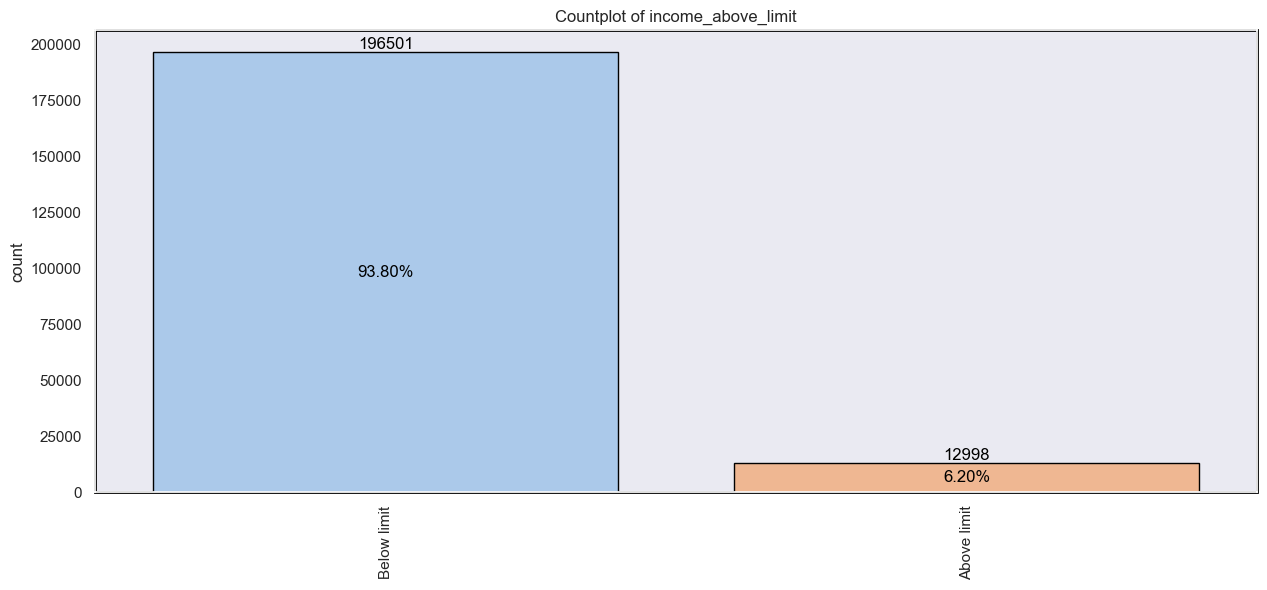

In [11]:
print(df_eda['income_above_limit'].value_counts())
plot_single_categorical_countplot(df_eda,'income_above_limit')

---
- **💵Economic Disparities:**
 
The data suggests that achieving income levels considered **"Above limit"** can be challenging for a significant portion of the population.

The prevalence of income inequality in the real world is indicated by the fact that approximately **94%** of individuals belong to the **"Below limit"** category. This imbalance depicts a profound implications on quality of life, access to opportunities, and overall well-being.

---
- **📌Class Imbalance:** 

The `Below limit` class is dominant, while the `Above limit` class is a minority.

---
⚠️ **Counterintuitive Target variable name:**

The name `income_above_limit` seem counterintuitive as it contains the values "Below limit" and "Above limit."

To make the variable name more intuitive, it's better to rename it to `income_status`.

In [12]:
df_eda.rename(columns={'income_above_limit': 'income_status'}, inplace=True)

columns_in_a_dataframe(df_eda)

Number of columns: 43
['ID', 'age', 'gender', 'education', 'class', 'education_institute', 'marital_status', 'race', 'is_hispanic', 'employment_commitment', 'unemployment_reason', 'employment_stat', 'wage_per_hour', 'is_labor_union', 'working_week_per_year', 'industry_code', 'industry_code_main', 'occupation_code', 'occupation_code_main', 'total_employed', 'household_stat', 'household_summary', 'under_18_family', 'veterans_admin_questionnaire', 'vet_benefit', 'tax_status', 'gains', 'losses', 'stocks_status', 'citizenship', 'mig_year', 'country_of_birth_own', 'country_of_birth_father', 'country_of_birth_mother', 'migration_code_change_in_msa', 'migration_prev_sunbelt', 'migration_code_move_within_reg', 'migration_code_change_in_reg', 'residence_1_year_ago', 'old_residence_reg', 'old_residence_state', 'importance_of_record', 'income_status']



### 📋Descriptive Statistics

In [13]:
df_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
age,209499.0,34.518728,22.306738,0.00,15.00,33.00,50.00,90.0
employment_stat,209499.0,0.176760,0.555562,0.00,0.00,0.00,0.00,2.0
wage_per_hour,209499.0,55.433487,276.757327,0.00,0.00,0.00,0.00,9999.0
working_week_per_year,209499.0,23.158850,24.397963,0.00,0.00,8.00,52.00,52.0
industry_code,209499.0,15.332398,18.049655,0.00,0.00,0.00,33.00,51.0
occupation_code,209499.0,11.321734,14.460839,0.00,0.00,0.00,26.00,46.0
total_employed,209499.0,1.956067,2.365154,0.00,0.00,1.00,4.00,6.0
vet_benefit,209499.0,1.515854,0.850853,0.00,2.00,2.00,2.00,2.0
gains,209499.0,435.926887,4696.359500,0.00,0.00,0.00,0.00,99999.0
losses,209499.0,36.881737,270.383302,0.00,0.00,0.00,0.00,4608.0


#### 🔍Observations:
- The minimum age is 0, which is unusual for someone to have an age of 0. This might be either the case of wrong or missing data.
Hence during preprocessing of data either these rows could be dropped or could be imputed.
- Columns 'age', 'employment_stat', 'wage_per_hour', 'gains', 'losses' and 'stocks_status' have `min`, `25%`, `50%` and `75%` all equal to **0**. This suggests that a large portion of the data in these columns might be concentrated around the value of 0.
- Columns `wage_per_hour`, `gains`, `losses`, `stocks_status` and `importance_of_record` have a very high Standard deviation. A high standard deviation can be influenced by **outliers**.

- This statistics also suggest possibilities of **outliers** in many columns.


In [65]:
def checking_zeroes(dataframe, columns):
    for column in columns:

        zero_counts = len(dataframe[dataframe[column] == 0])
        not_zero_counts = len(dataframe) - zero_counts
        per_zero_counts = 100 * zero_counts / len(dataframe)
        per_not_zero_counts = 100 * not_zero_counts / len(dataframe)

        print(f"Number of values in '{column}' column equal to 0: {zero_counts} ({per_zero_counts:.2f}%)")
        print(f"Number of values in '{column}' column not equal to 0: {not_zero_counts} ({per_not_zero_counts:.2f}%)\n")


In [67]:
checking_zeroes(df_eda, ['age', 'employment_stat', 'wage_per_hour',  
                         'gains', 'losses', 'stocks_status', 'working_week_per_year',
                         'total_employed', 'vet_benefit'])

Number of values in 'age' column equal to 0: 3041 (1.45%)
Number of values in 'age' column not equal to 0: 206458 (98.55%)

Number of values in 'employment_stat' column equal to 0: 189556 (90.48%)
Number of values in 'employment_stat' column not equal to 0: 19943 (9.52%)

Number of values in 'wage_per_hour' column equal to 0: 197643 (94.34%)
Number of values in 'wage_per_hour' column not equal to 0: 11856 (5.66%)

Number of values in 'gains' column equal to 0: 201669 (96.26%)
Number of values in 'gains' column not equal to 0: 7830 (3.74%)

Number of values in 'losses' column equal to 0: 205437 (98.06%)
Number of values in 'losses' column not equal to 0: 4062 (1.94%)

Number of values in 'stocks_status' column equal to 0: 187467 (89.48%)
Number of values in 'stocks_status' column not equal to 0: 22032 (10.52%)

Number of values in 'working_week_per_year' column equal to 0: 100688 (48.06%)
Number of values in 'working_week_per_year' column not equal to 0: 108811 (51.94%)

Number of value

#### 🔍Observations:
- Columns `employment_stat`, `wage_per_hour`, `gains`, `losses`, and `stocks_status` all have 0 as dominant value.
This heavy imbalance may affect the performance of machine learning models to accurately predict the minority class (non-zero values) due to limited examples. 

- Columns `working_week_per_year`, `total_employed` and ` vet_benefit` have a significant number of 0 as values.

In [14]:
df_eda.describe(include='object').T

,count,unique,top,freq
ID,209499,209499,ID_TZ0000,1
gender,209499,2,Female,108784
education,209499,17,High school graduate,50627
class,104254,8,Private,75617
education_institute,13302,2,High school,7247
marital_status,209499,7,Never married,90723
race,209499,5,White,175709
is_hispanic,209499,10,All other,180404
employment_commitment,209499,8,Children or Armed Forces,129789
unemployment_reason,6520,5,Other job loser,2242


### 👯Duplicate Values

In [15]:
print(f"Number of duplicate instances in the dataset: {df_eda.duplicated().sum()}")

Number of duplicate instances in the dataset: 0


### 🕳️Missing Values

In [16]:
missing_values_table(df_eda) #Function defined above

Your selected dataframe has 43 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
veterans_admin_questionnaire,207415,99.0
unemployment_reason,202979,96.9
education_institute,196197,93.7
old_residence_reg,193148,92.2
old_residence_state,193148,92.2
is_labor_union,189420,90.4
under_18_family,151654,72.4
residence_1_year_ago,106284,50.7
occupation_code_main,105694,50.5
class,105245,50.2


### 🧩Unique Values

In [17]:
df_eda.nunique().sort_values(ascending=False)

ID                                209499
importance_of_record              102743
stocks_status                       1499
wage_per_hour                       1232
gains                                132
losses                               114
age                                   91
working_week_per_year                 53
industry_code                         52
old_residence_state                   50
occupation_code                       47
country_of_birth_mother               43
country_of_birth_father               43
country_of_birth_own                  43
household_stat                        38
industry_code_main                    24
education                             17
occupation_code_main                  14
is_hispanic                           10
migration_code_change_in_msa           9
migration_code_move_within_reg         9
migration_code_change_in_reg           8
household_summary                      8
employment_commitment                  8
class           

In [23]:
unique_values_per_column(df_eda,50)

Column: gender
Number of Unique values: 2
Unique values: Female, Male

Column: education
Number of Unique values: 17
Unique values: High school graduate, 12th grade no diploma, Children, Bachelors degree(BA AB BS), 7th and 8th grade, 11th grade, 9th grade, Masters degree(MA MS MEng MEd MSW MBA), 10th grade, Associates degree-academic program, 1st 2nd 3rd or 4th grade, Some college but no degree, Less than 1st grade, Associates degree-occup /vocational, Prof school degree (MD DDS DVM LLB JD), 5th or 6th grade, Doctorate degree(PhD EdD)

Column: class
Number of Unique values: 9
Unique values: nan, Federal government, Private, Local government, Self-employed-incorporated, Self-employed-not incorporated, State government, Without pay, Never worked

Column: education_institute
Number of Unique values: 3
Unique values: nan, High school, College or university

Column: marital_status
Number of Unique values: 7
Unique values: Widowed, Never married, Married-civilian spouse present, Divorced, Ma

⚠️ There is a value '?' which represents the missing nature of data so could be replaced with a NULL value.

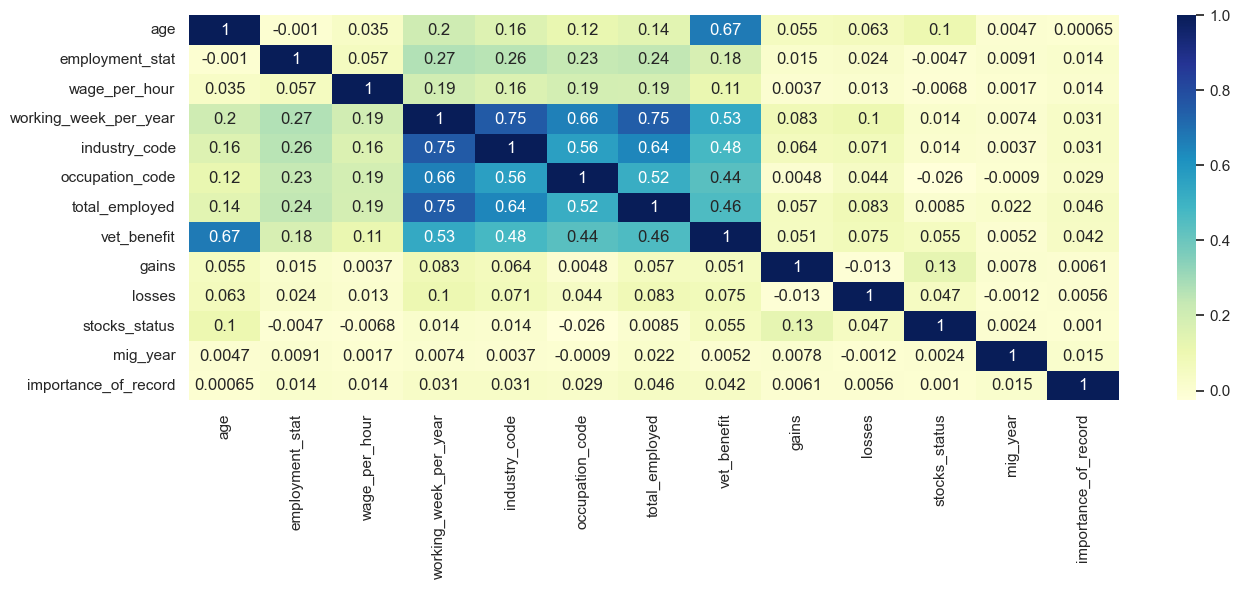

In [18]:
# Heatmap
plt.figure(figsize =(15,5))
sns.heatmap(df_eda.corr(numeric_only = True),annot = True,cmap = "YlGnBu")
plt.show()

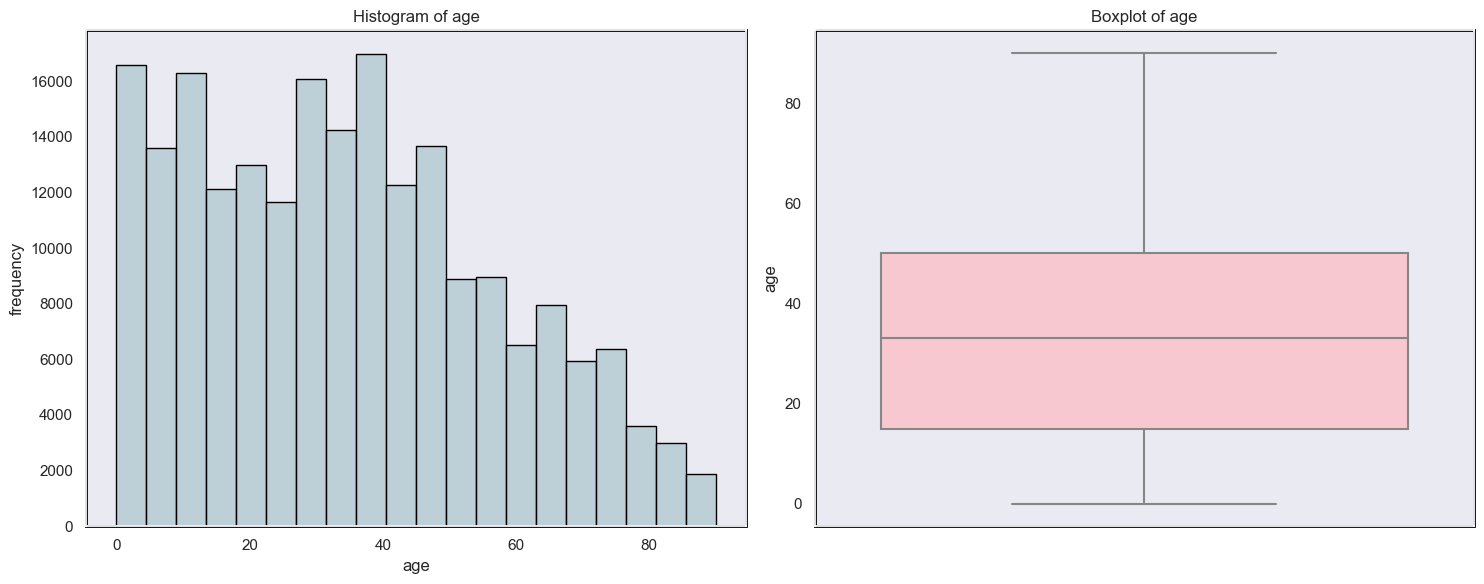

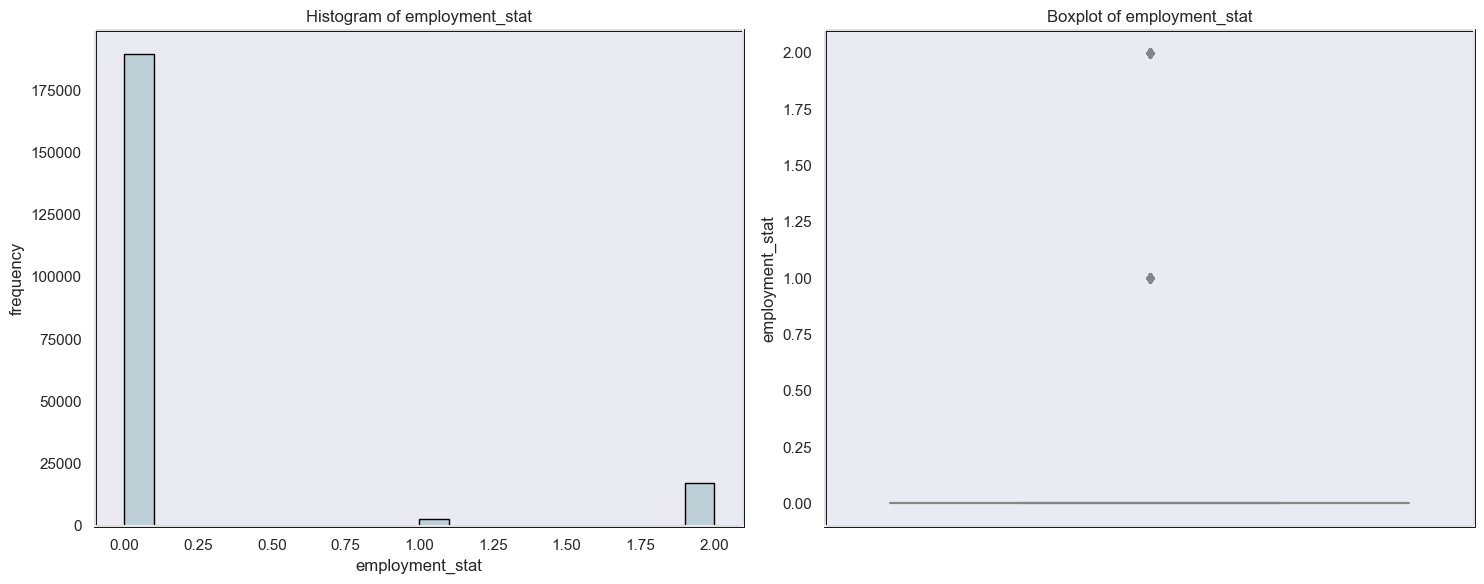

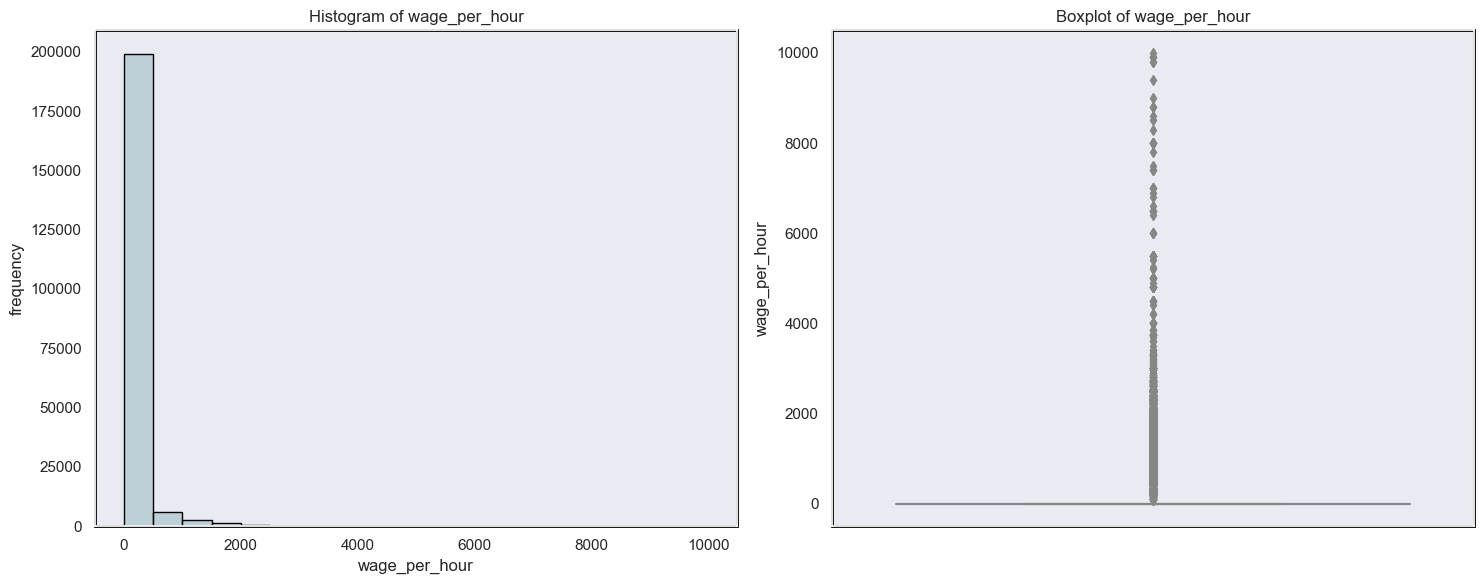

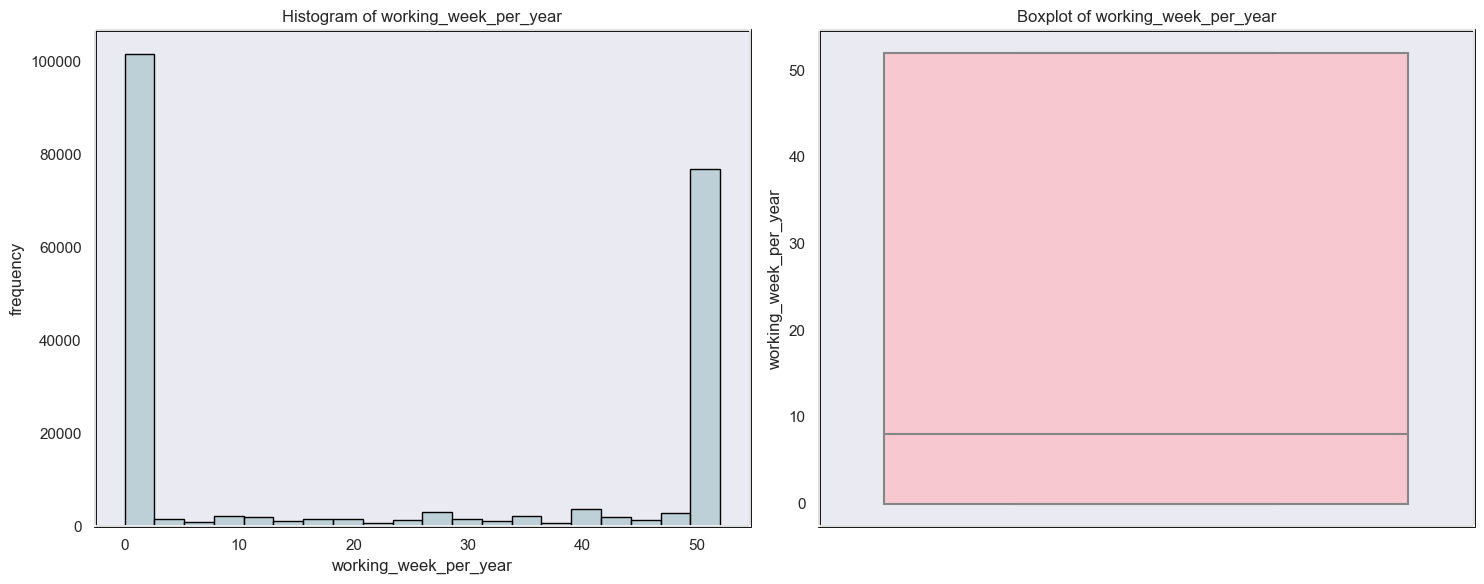

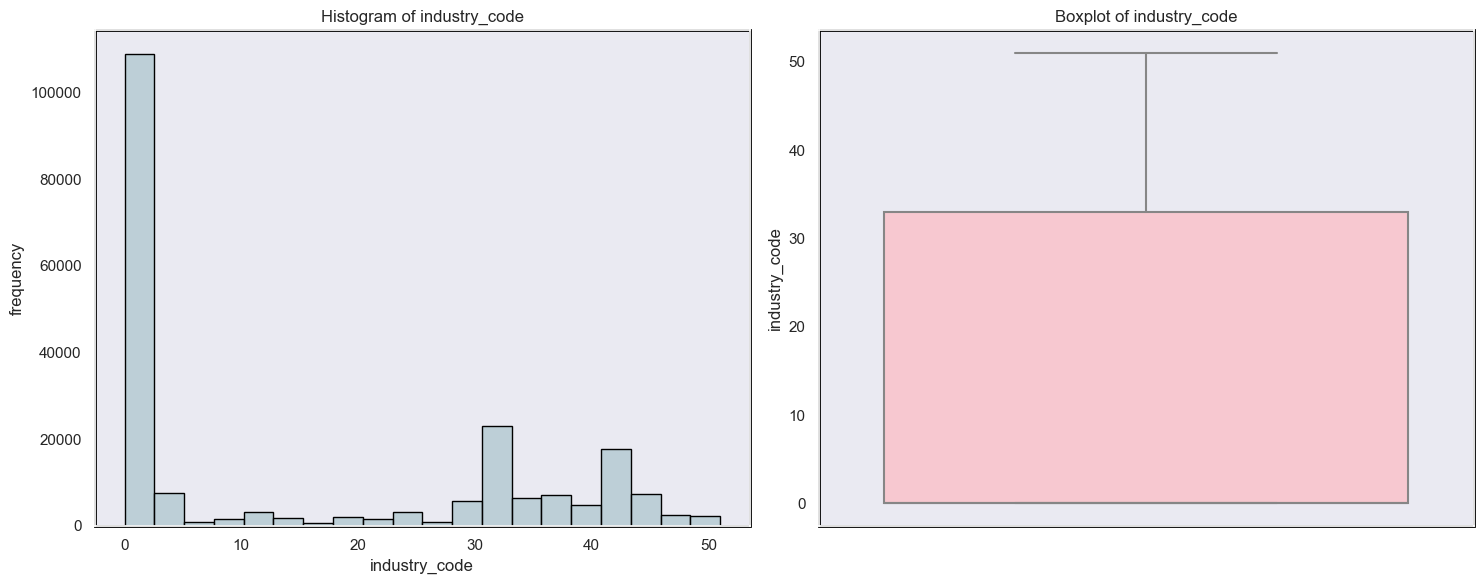

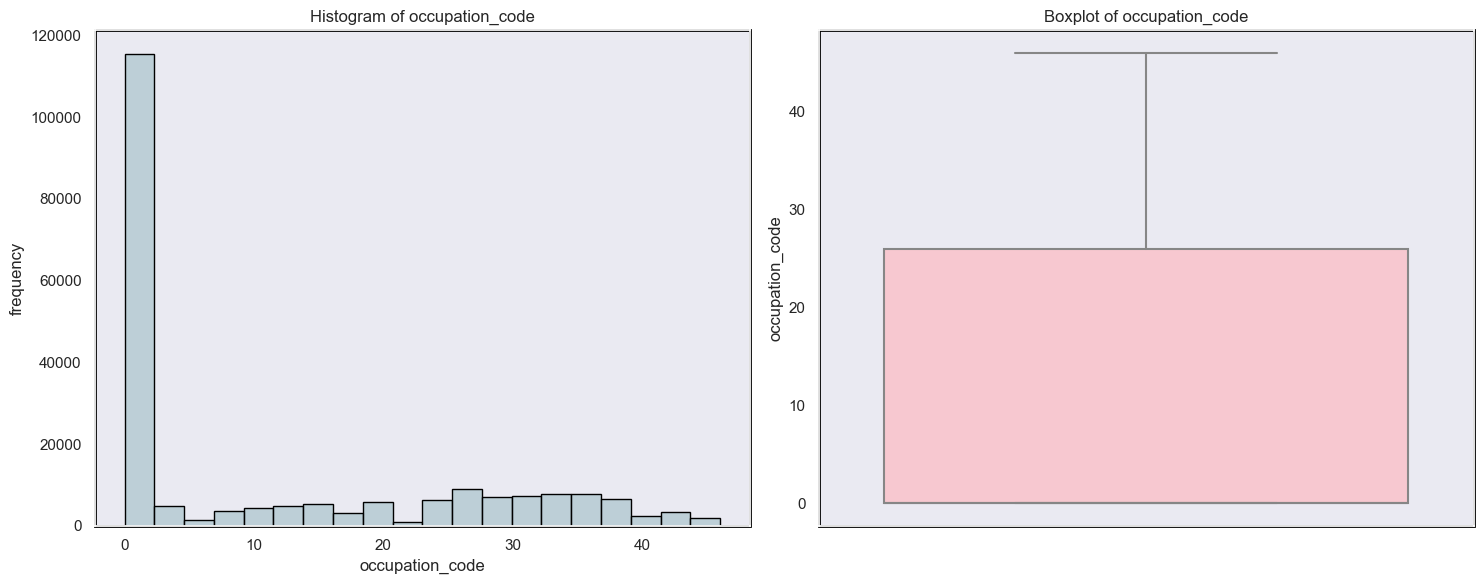

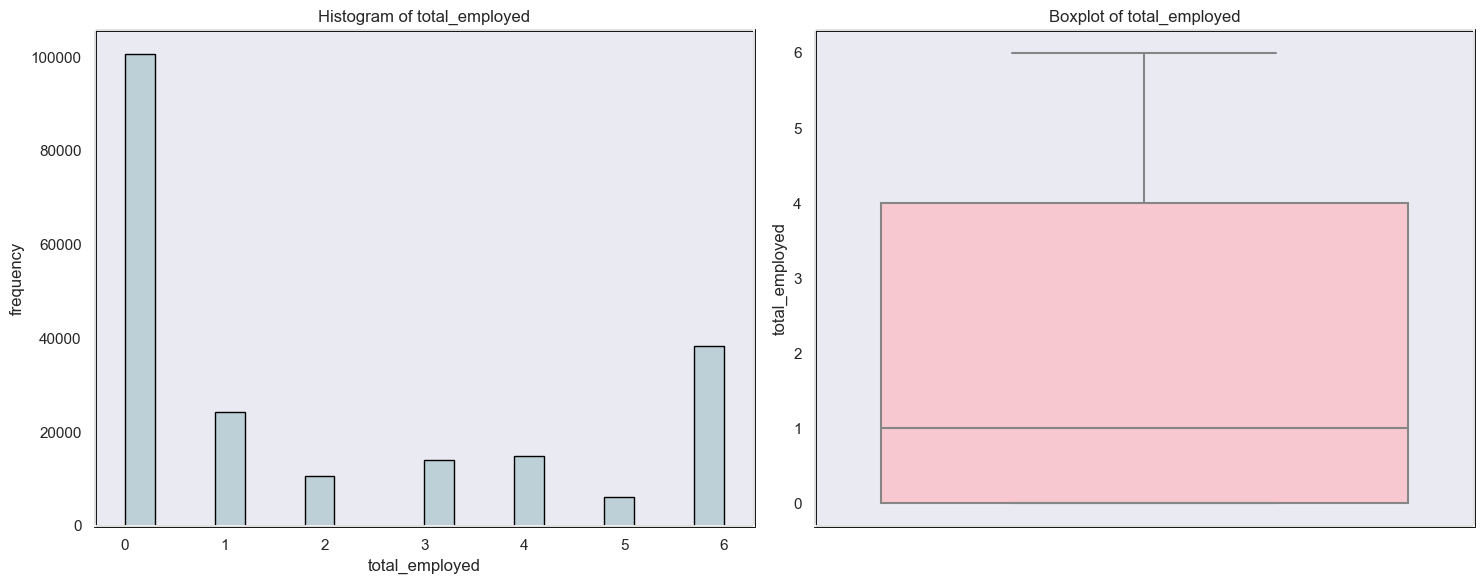

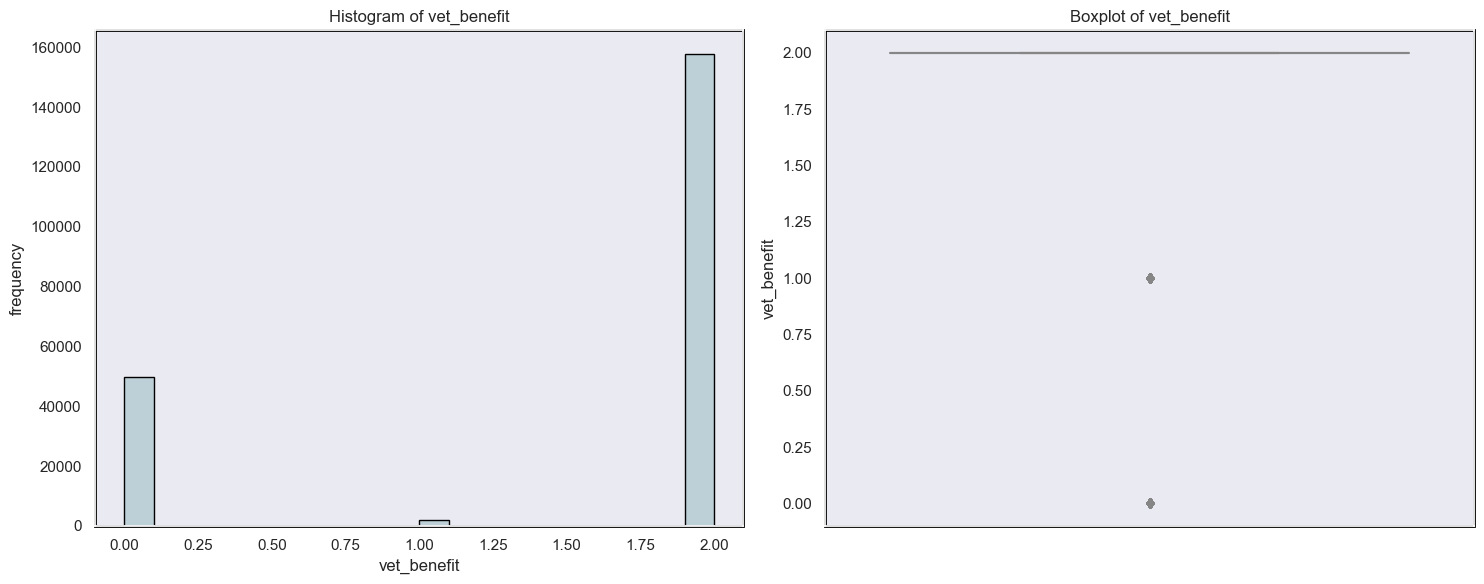

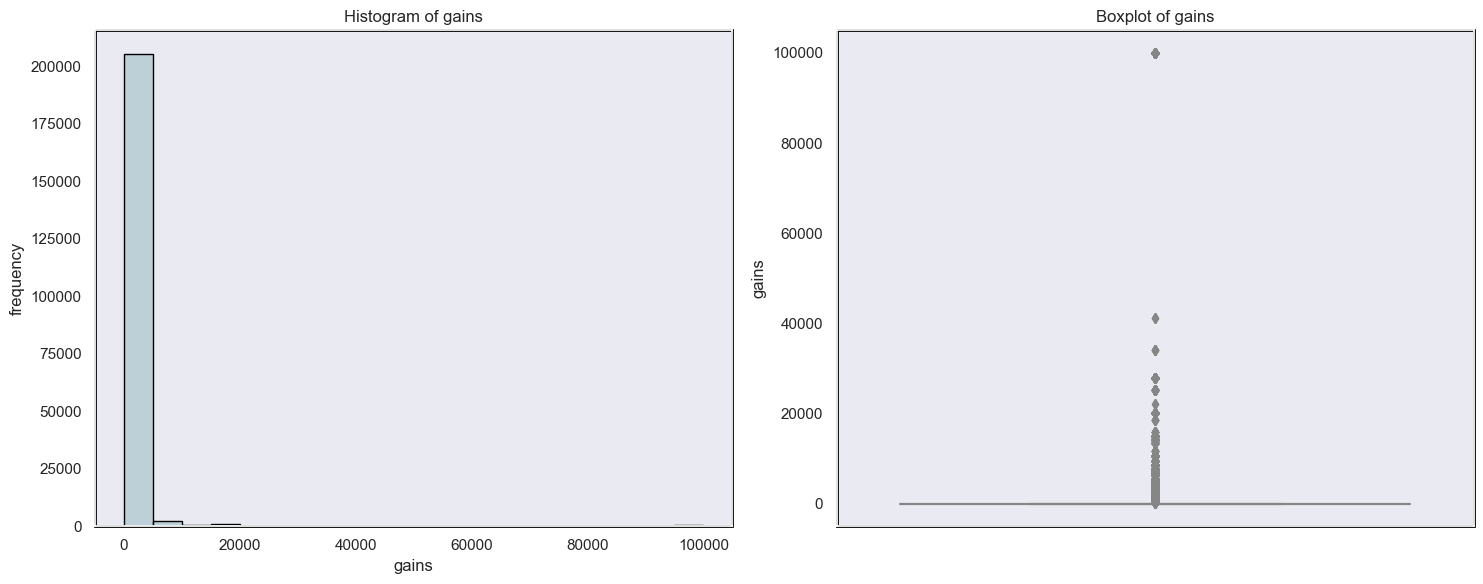

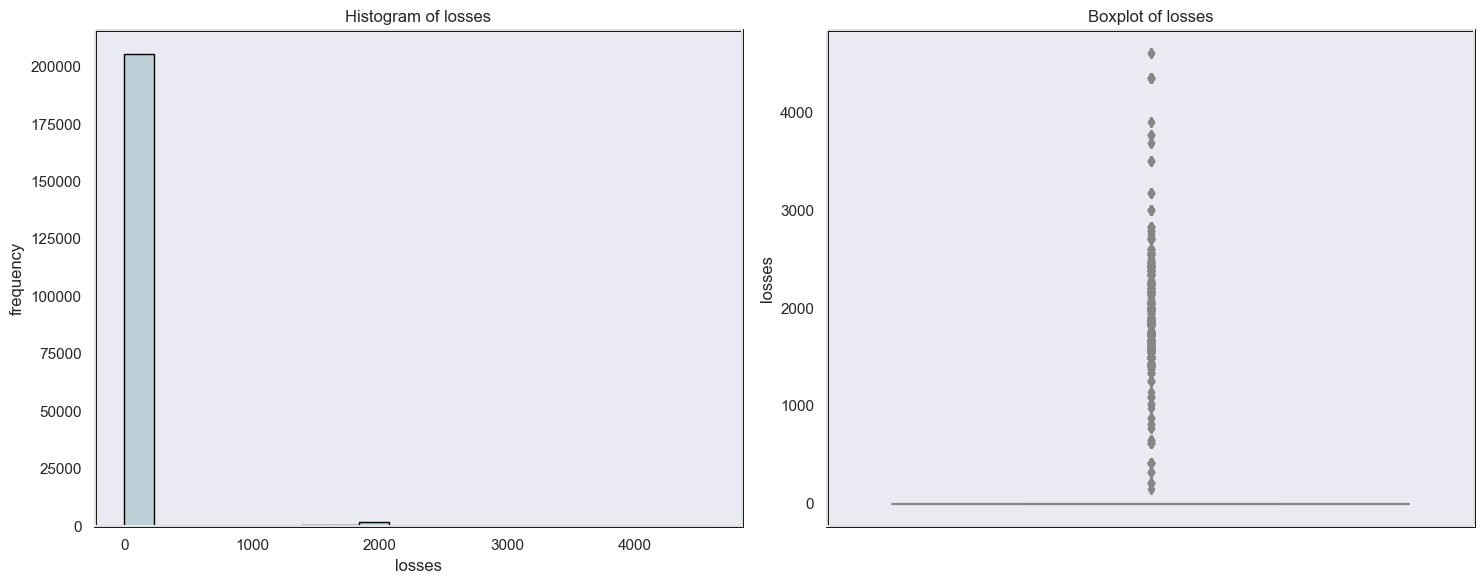

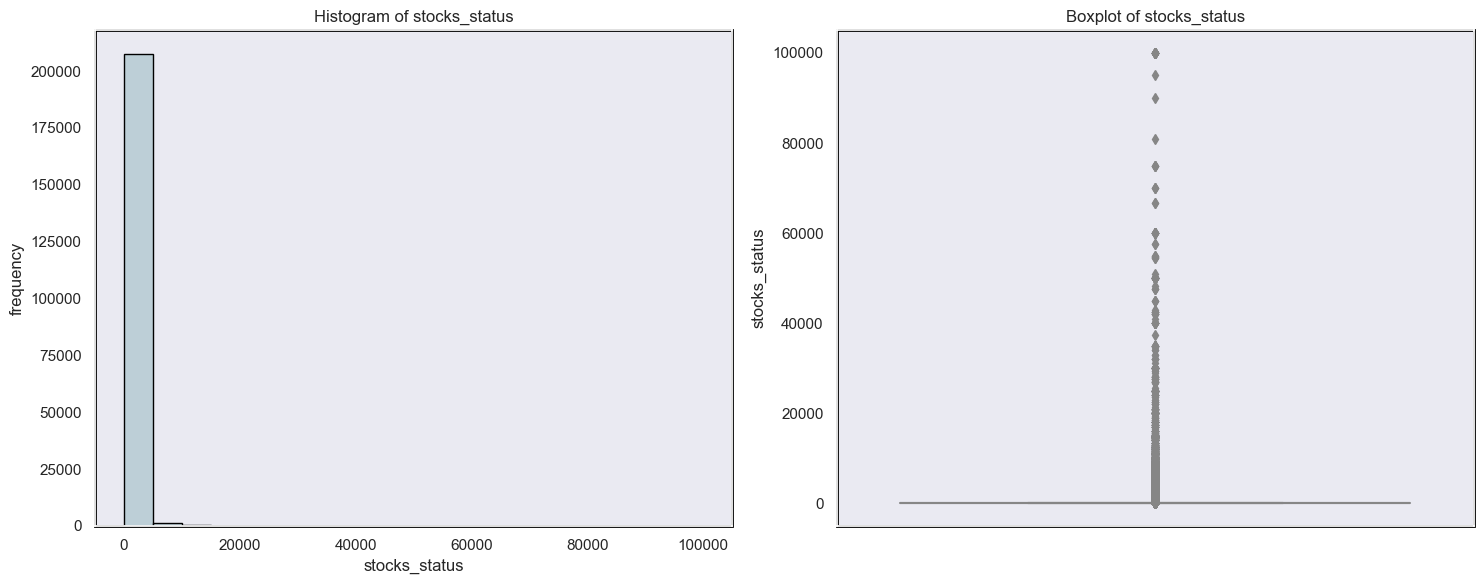

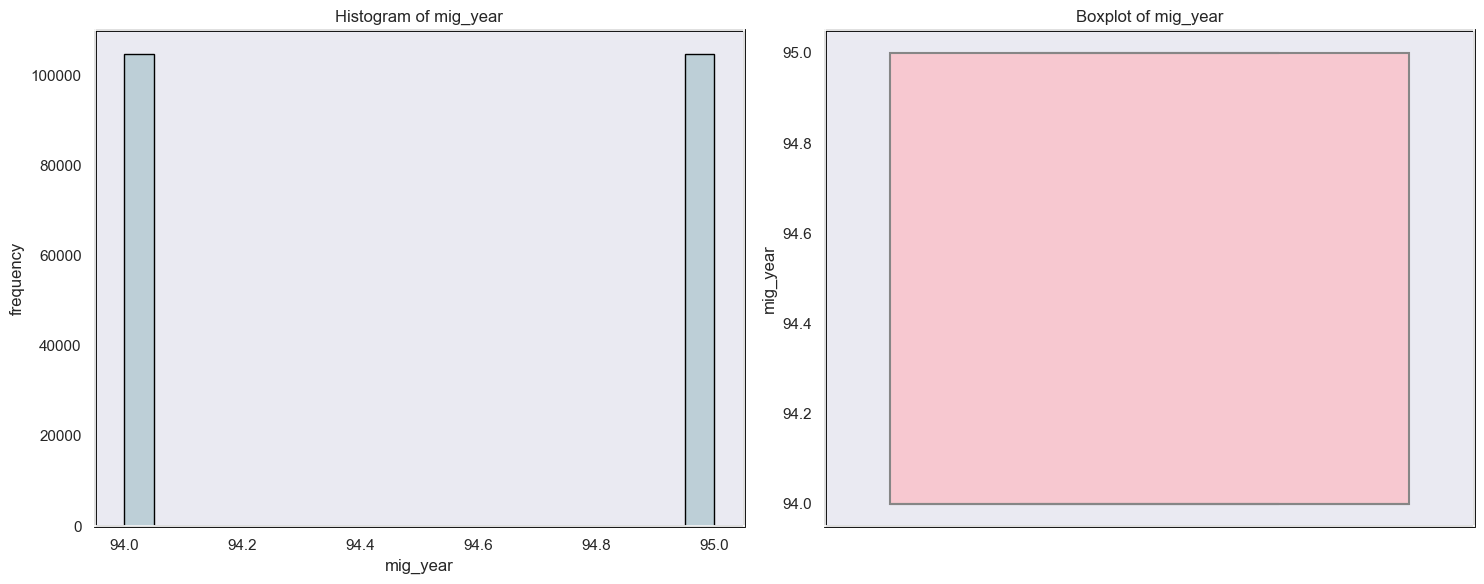

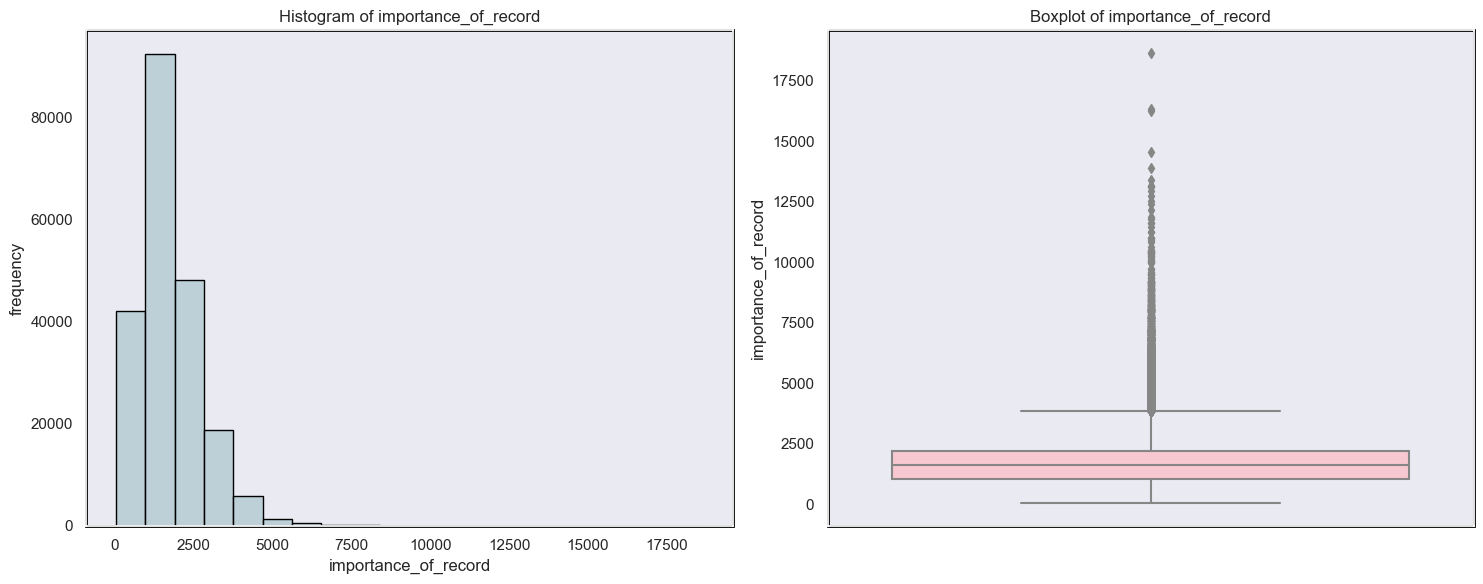

In [19]:
plot_numerical_histogram_boxplot(df_eda)

In [41]:
know_a_column(df_eda,'importance_of_record')

Number of Missing value in the importance_of_record column: 0
Percentage of missing values: 0.0

importance_of_record column is of data type : float64

Descriptive statistics: 

count    209499.000000
mean       1740.888324
std         995.559557
min          37.870000
25%        1061.290000
50%        1617.040000
75%        2185.480000
max       18656.300000
Name: importance_of_record, dtype: float64


Number of unique values: 102743
value count in importance_of_record
1191.21    35
753.23     33
1033.67    31
1138.19    30
988.79     30
           ..
904.00      1
3554.66     1
908.54      1
890.59      1
791.61      1
Name: count, Length: 102743, dtype: int64


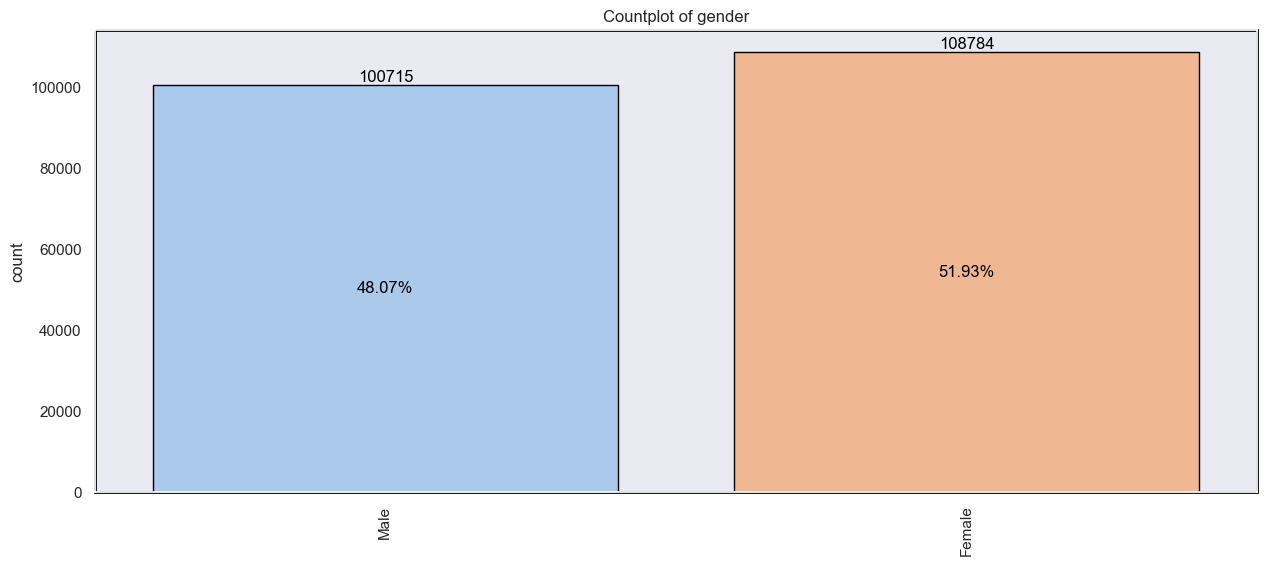

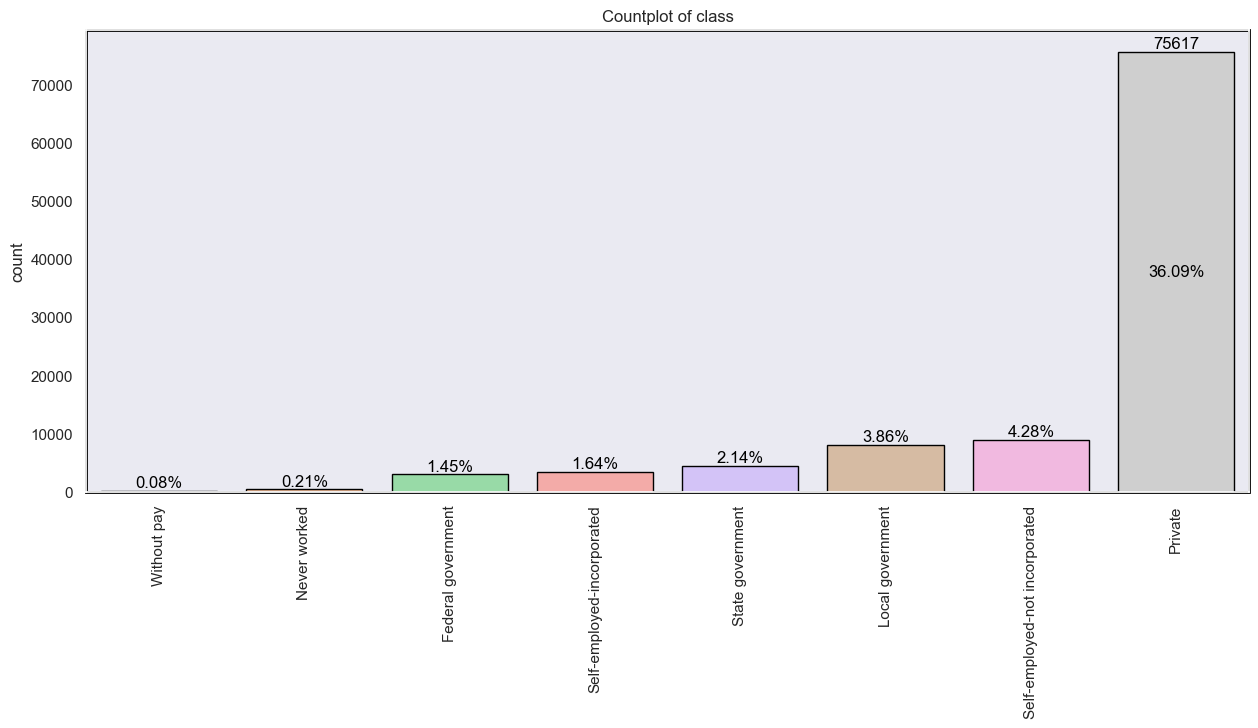

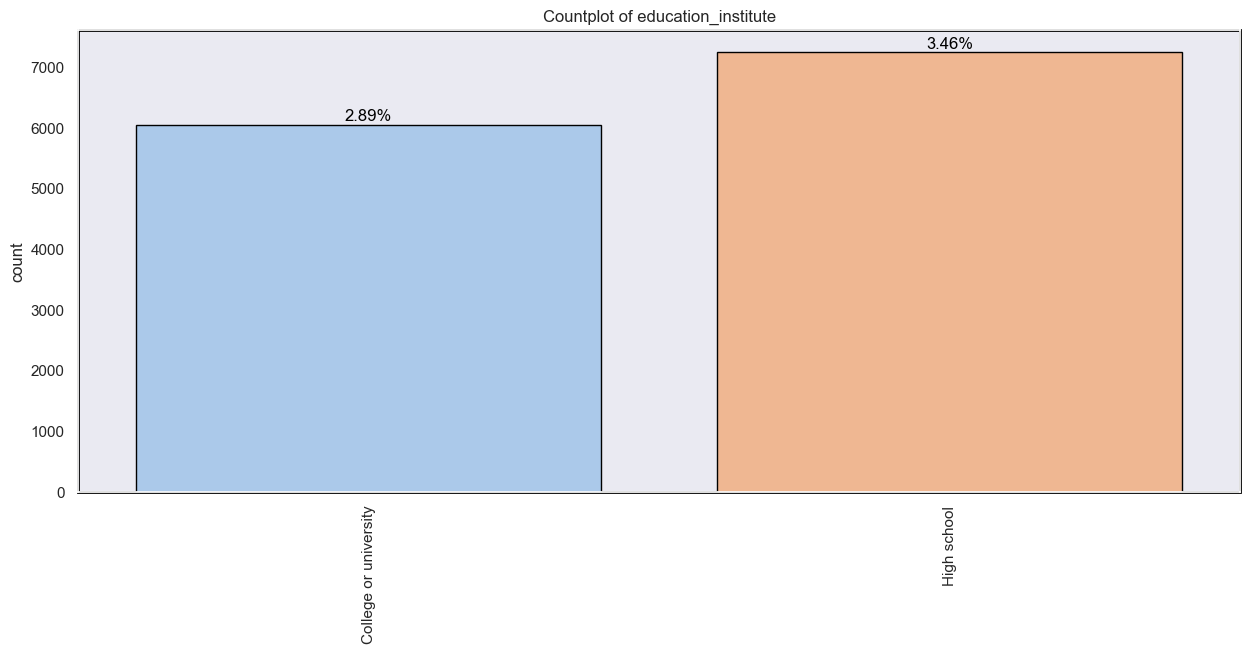

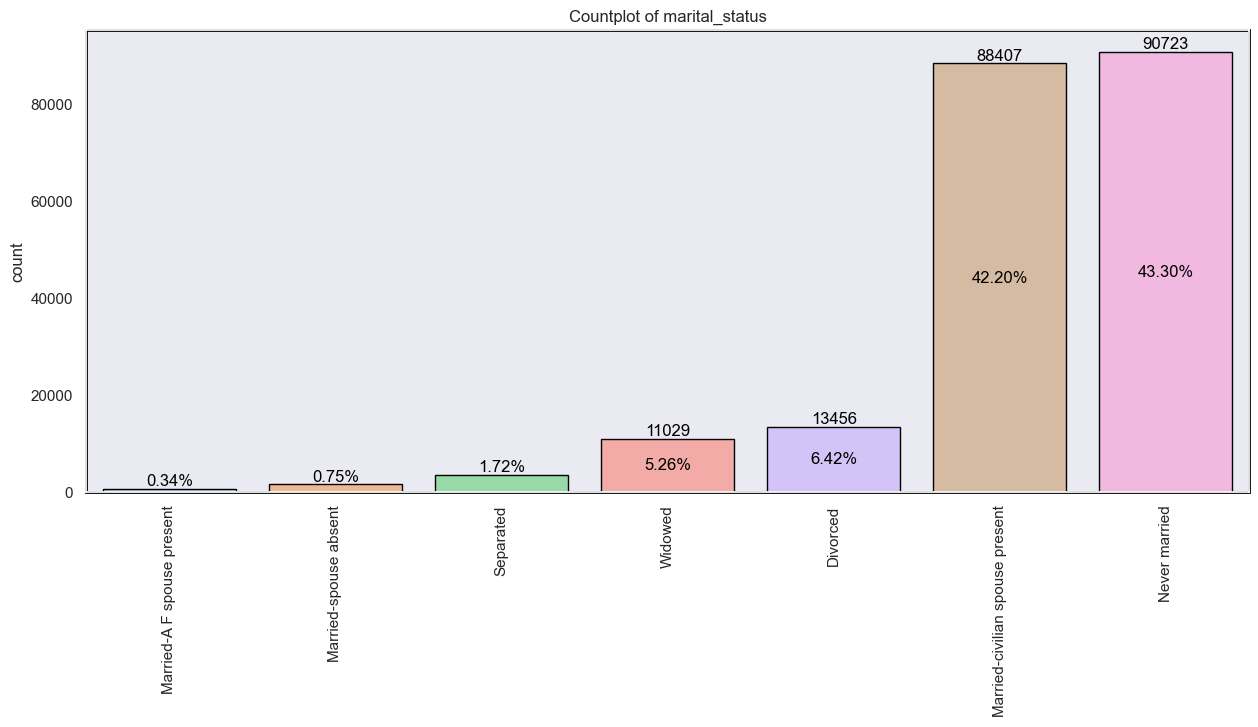

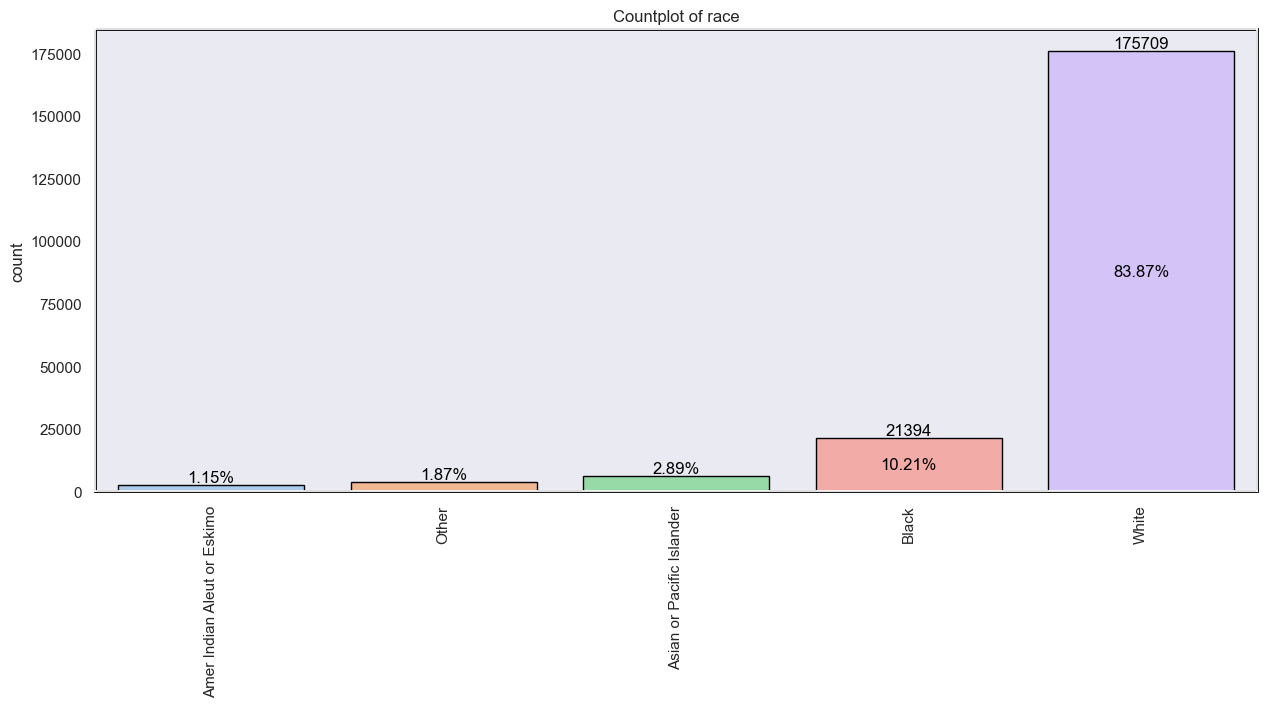

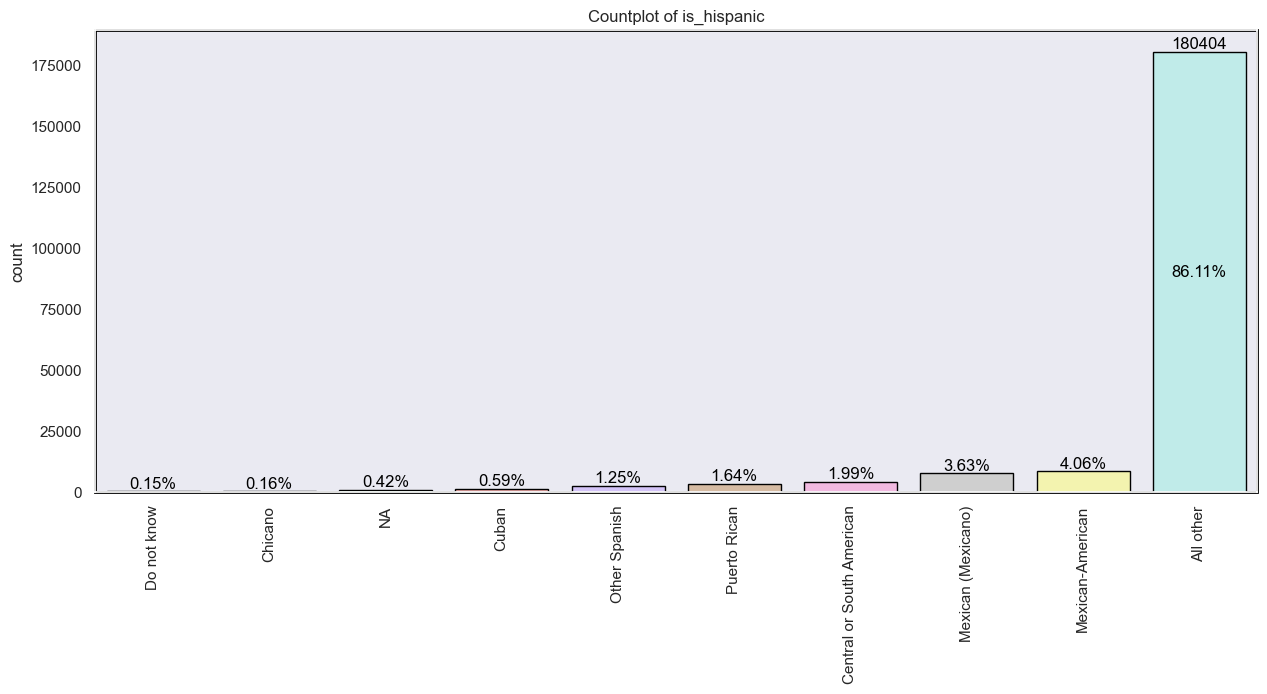

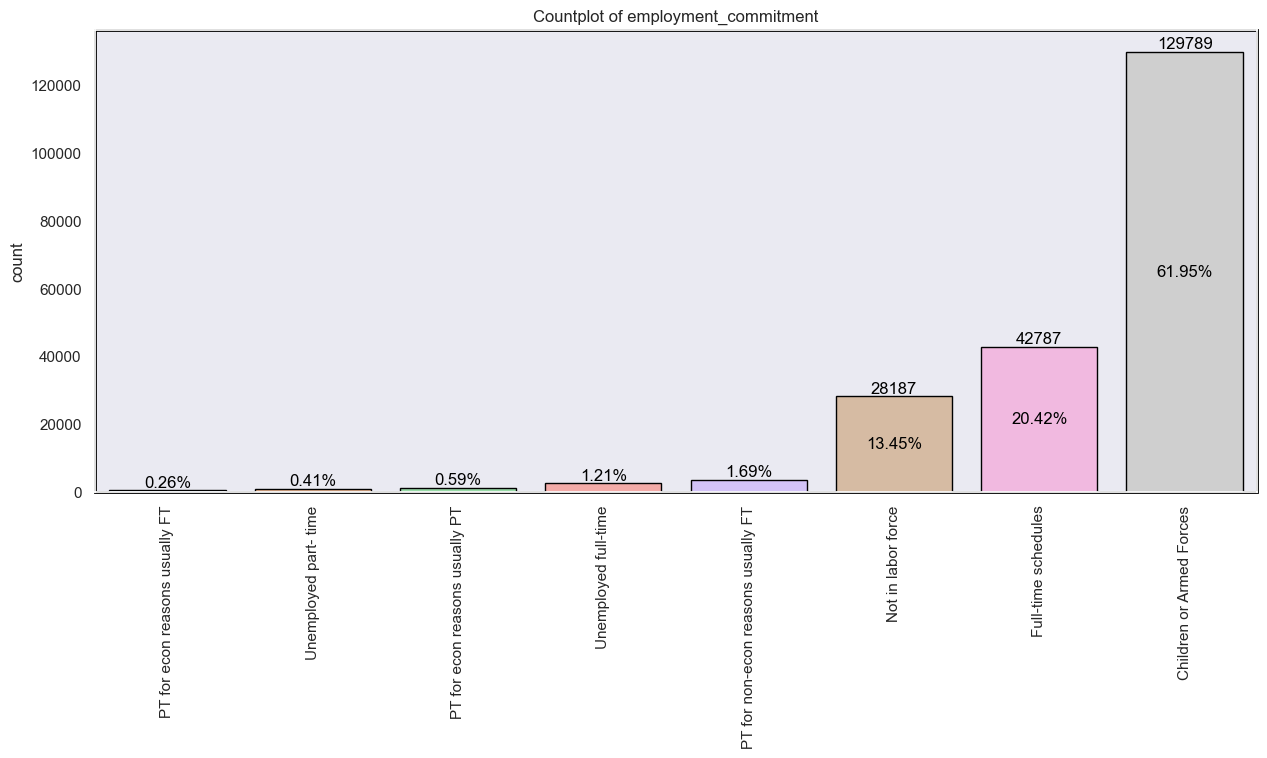

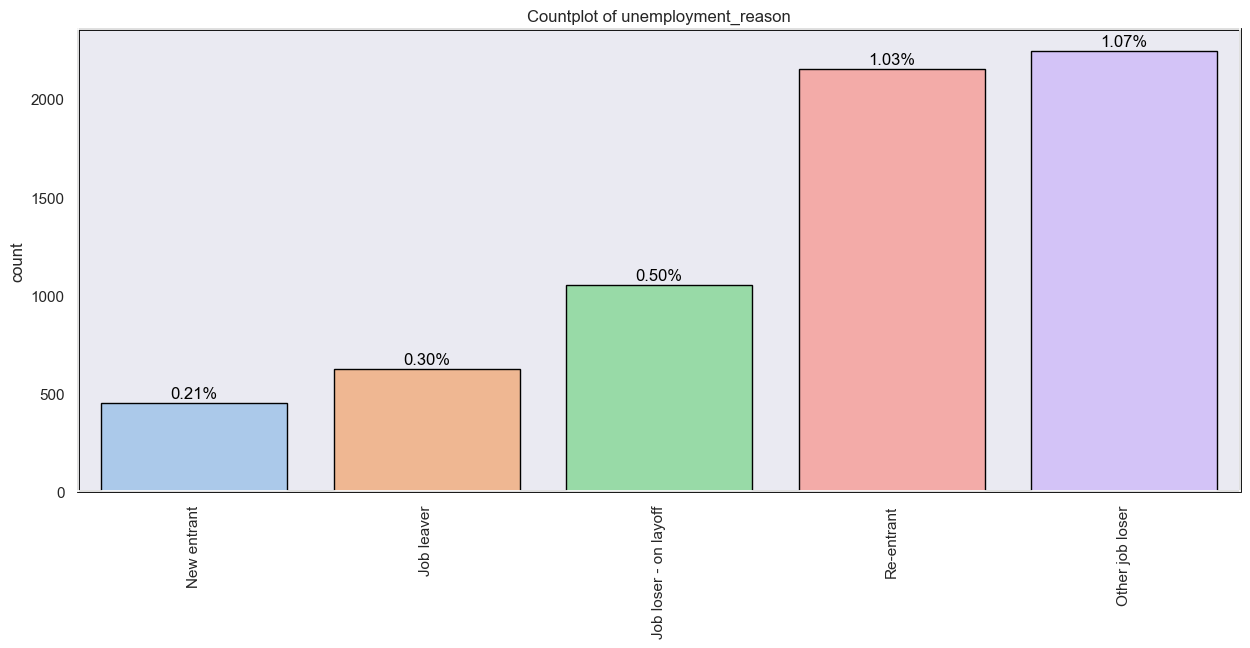

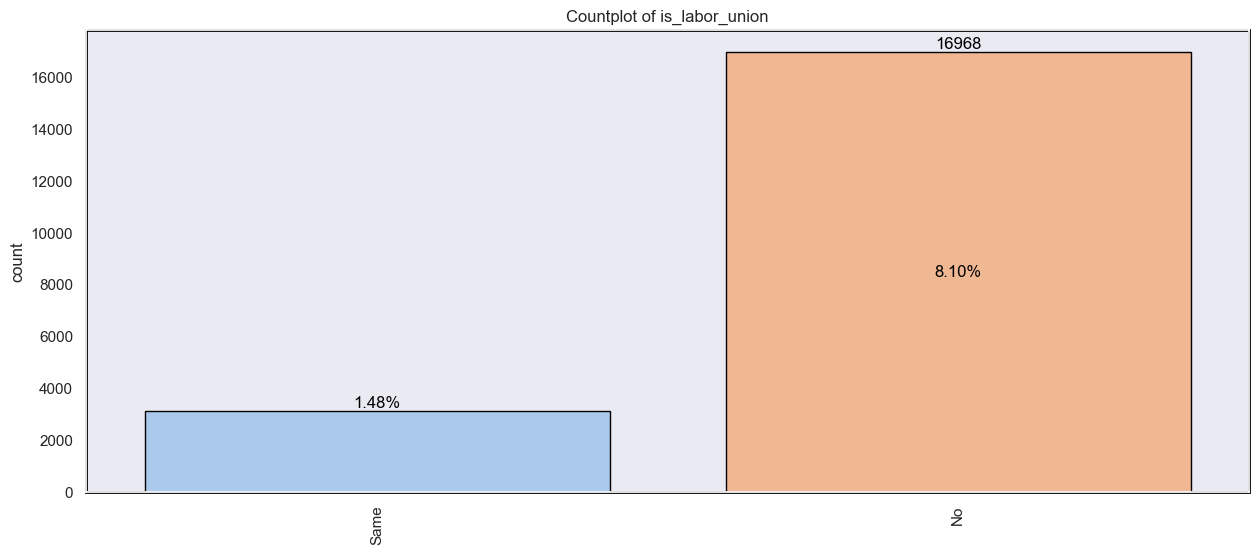

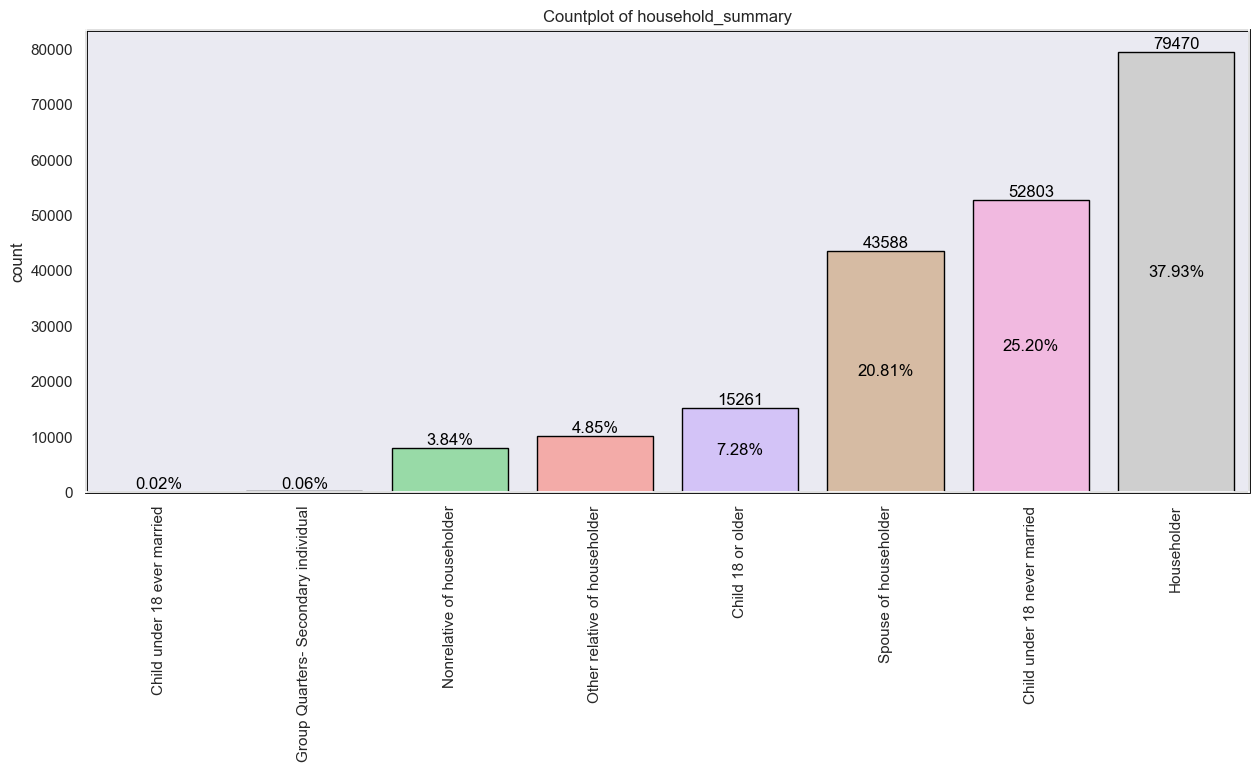

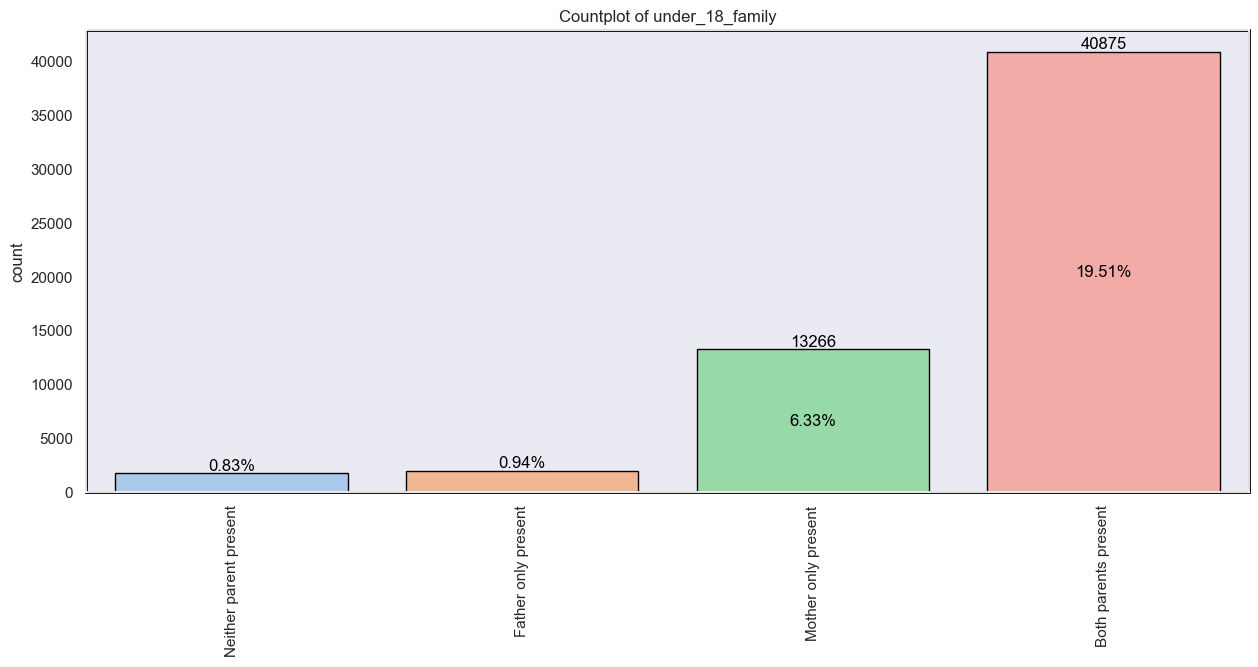

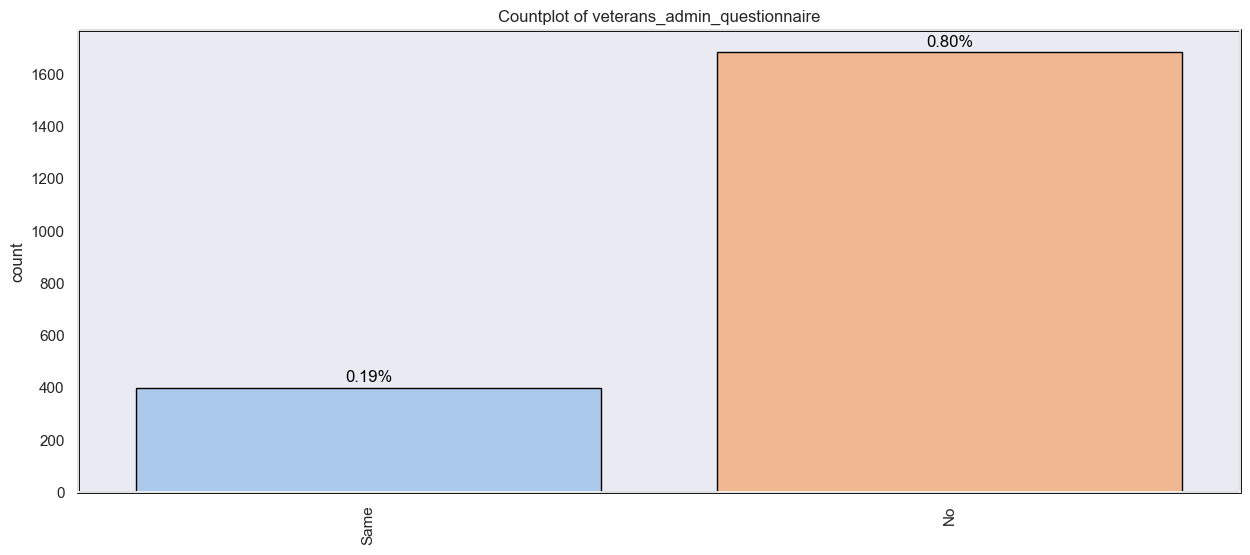

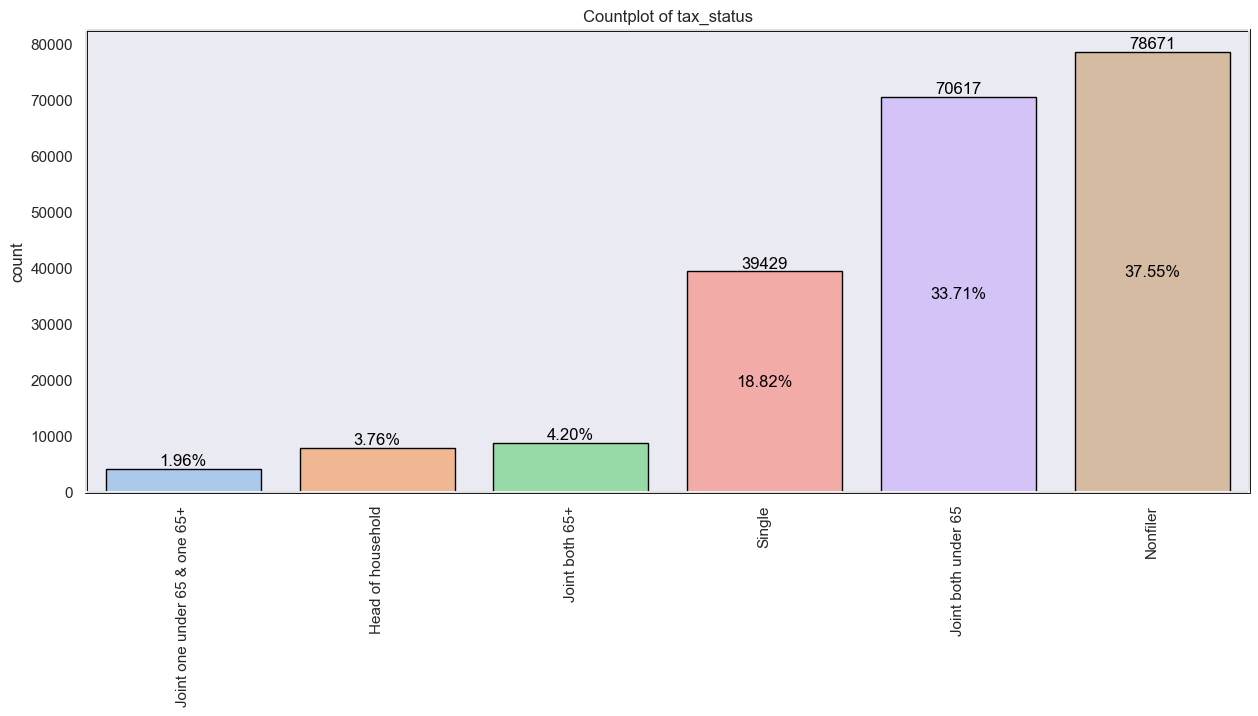

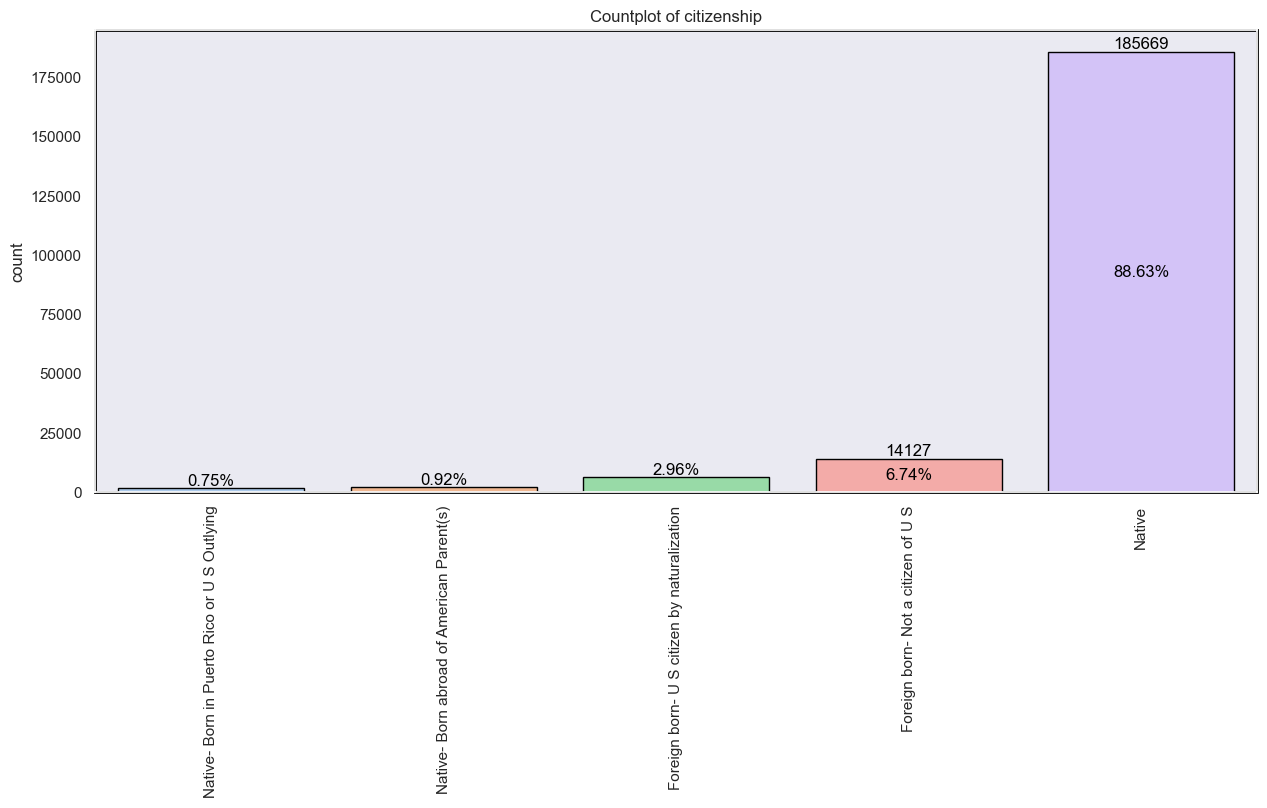

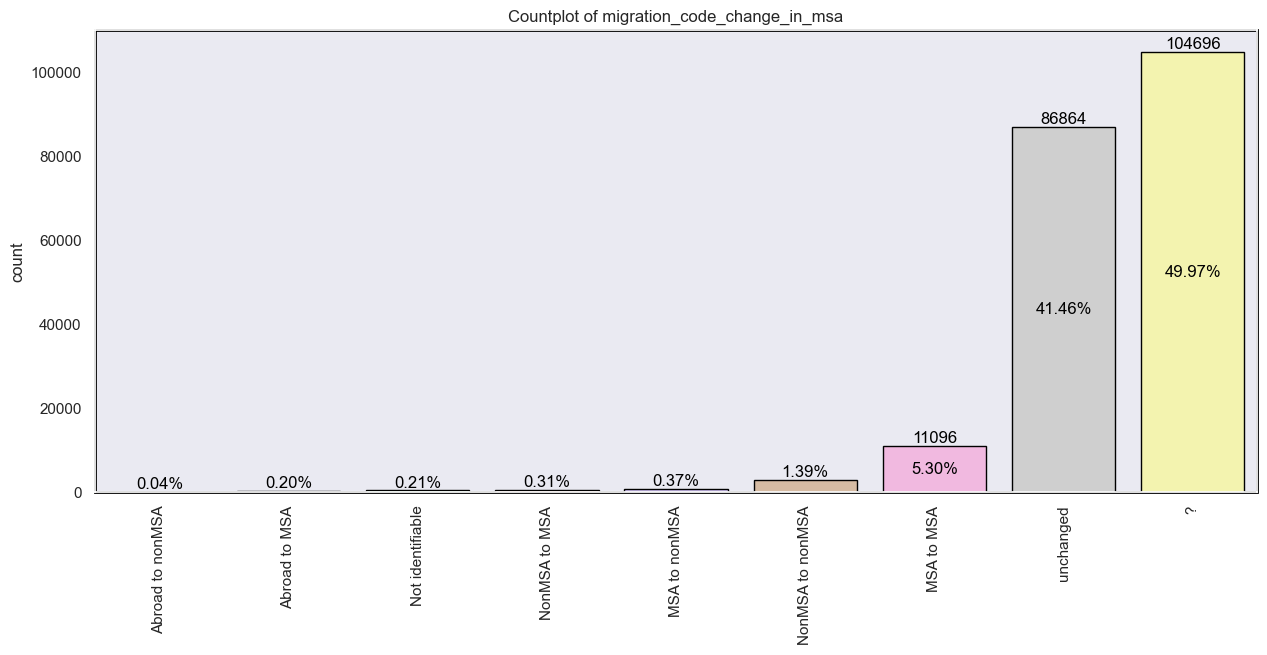

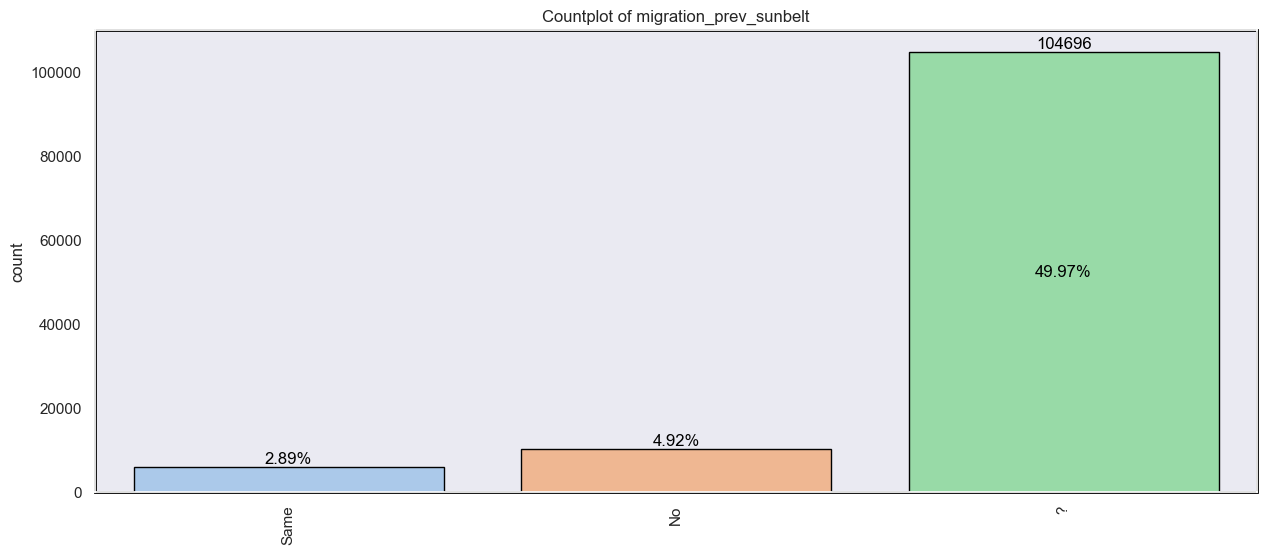

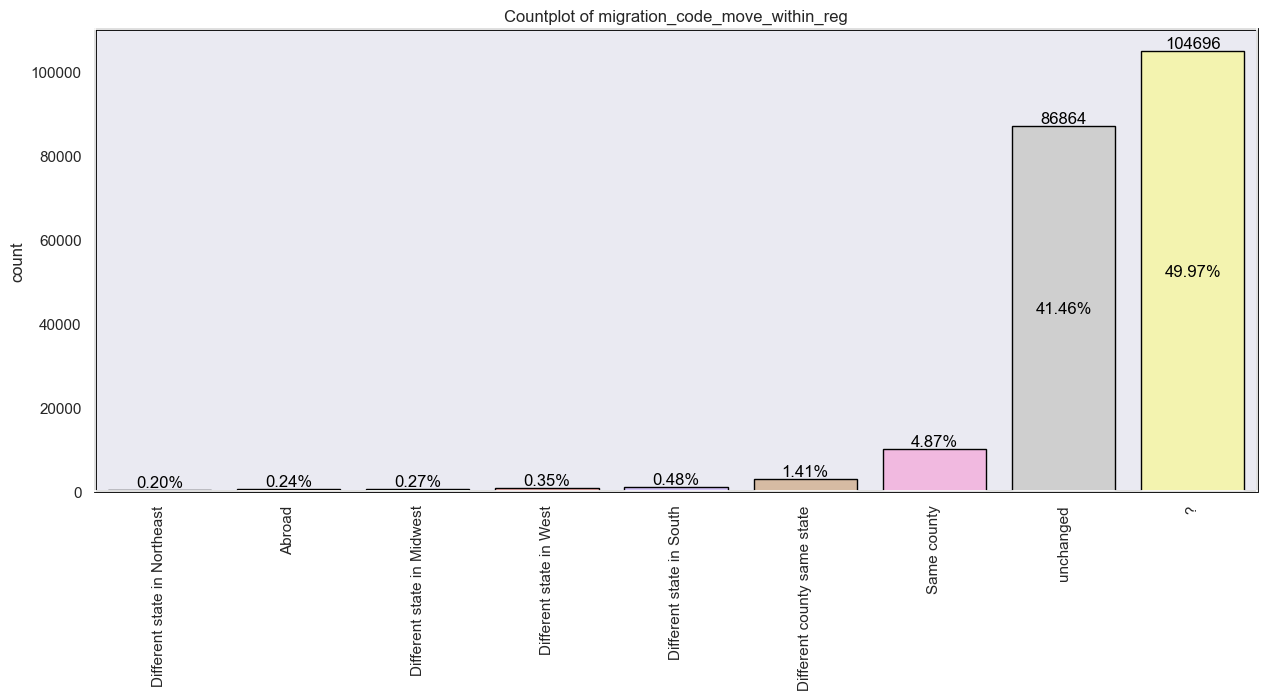

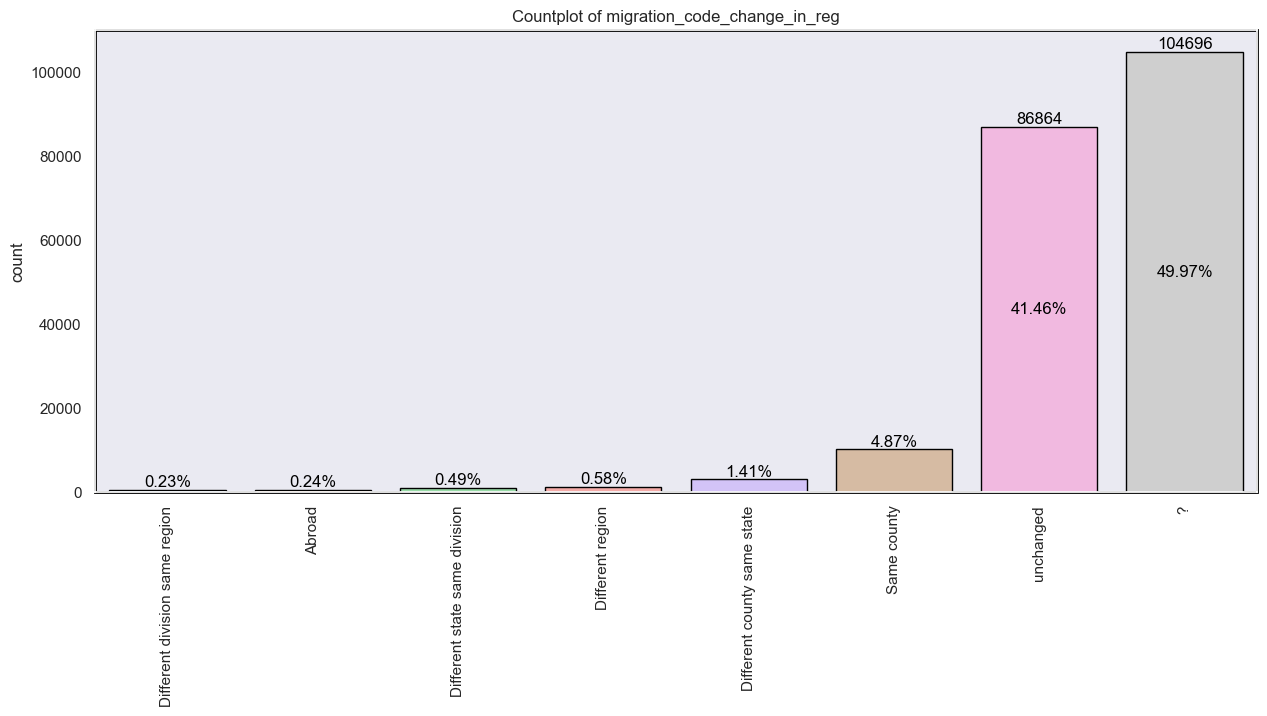

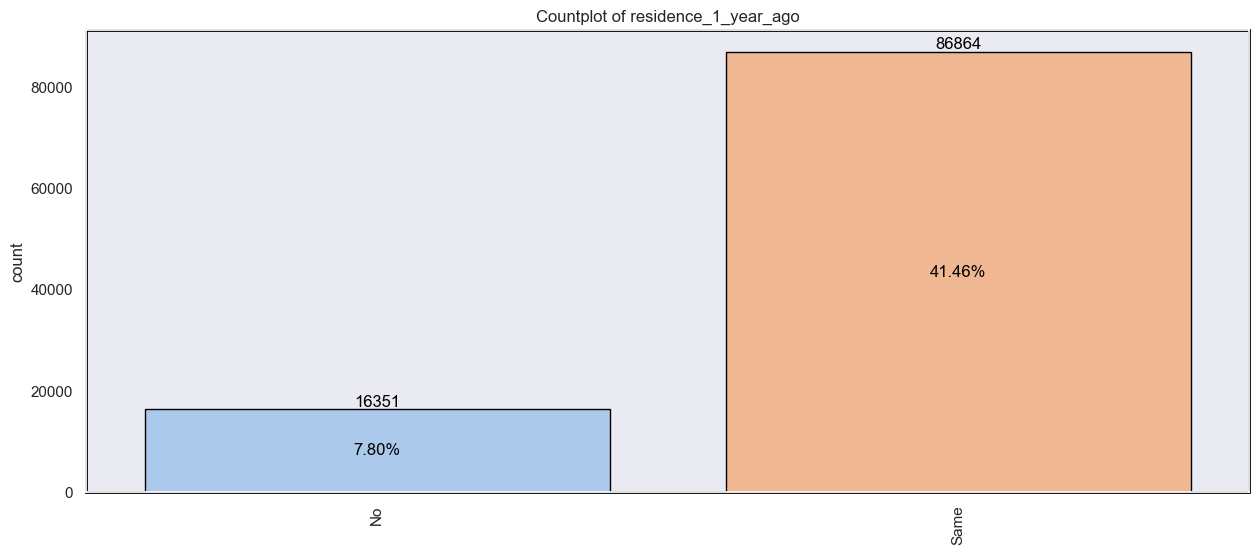

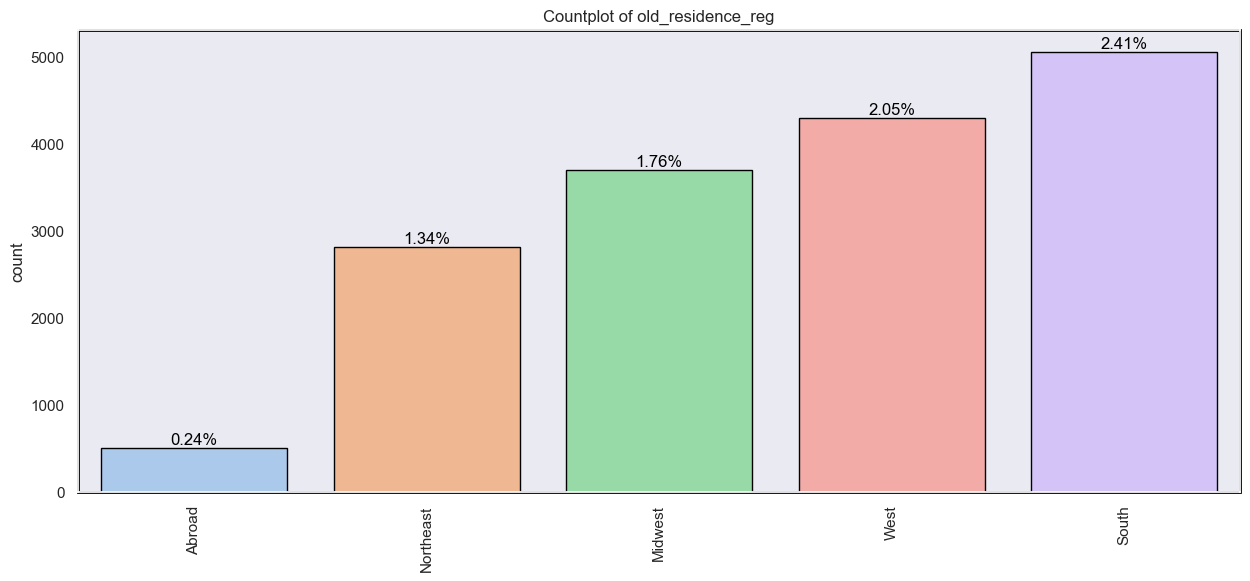

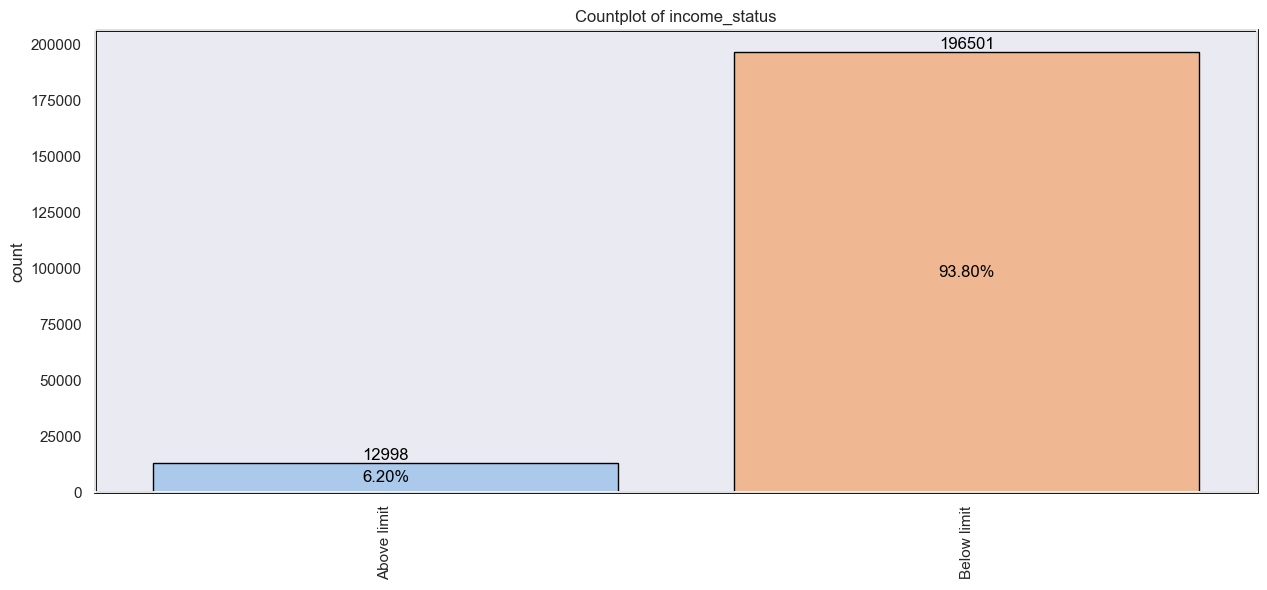

In [20]:
plot_categorical_countplots(df_eda)

In [76]:
def know_a_column(dataframe, column):
    missing_values = dataframe[column].isnull().sum()
    percentage = missing_values / len(dataframe) * 100
    print(f"Number of Missing value in the {column} column: {missing_values} ({percentage:.2f}%)\n")
    print(f"{column} column is of data type : {dataframe[column].dtype}\n")
    print("Descriptive statistics: \n")
    if dataframe[column].dtype != 'object':
        print(dataframe[column].describe())
        print("\n")
    else:
        print(dataframe[column].describe(include='object'))
        print("\n")
    print(f"Number of unique values: {dataframe[column].nunique()}")
    print(f"value count in {dataframe[column].value_counts()}")

In [77]:
know_a_column(df_eda, 'stocks_status')

Number of Missing value in the stocks_status column: 0 (0.00%)

stocks_status column is of data type : int64

Descriptive statistics: 

count    209499.000000
mean        194.533420
std        1956.375501
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       99999.000000
Name: stocks_status, dtype: float64


Number of unique values: 1499
value count in stocks_status
0       187467
100       1202
500       1061
200        969
1000       948
         ...  
1085         1
3396         1
358          1
627          1
3508         1
Name: count, Length: 1499, dtype: int64


## Preprocessing

In [22]:
df_to_preprocess = df_eda.copy(deep=True)

In [24]:
df_to_preprocess.replace(['?'], np.nan, inplace=True)

In [25]:
missing_values_table(df_to_preprocess)

Your selected dataframe has 43 columns.
There are 17 columns that have missing values.


,Missing Values,% of Total Values
veterans_admin_questionnaire,207415,99.0
unemployment_reason,202979,96.9
education_institute,196197,93.7
old_residence_state,193889,92.5
old_residence_reg,193148,92.2
migration_prev_sunbelt,193148,92.2
is_labor_union,189420,90.4
under_18_family,151654,72.4
migration_code_change_in_reg,106284,50.7
residence_1_year_ago,106284,50.7


In [94]:
df_to_impute = df_to_preprocess.copy(deep=True)

### ✍️Imputing 0's in `age` column
Let's see if `under_18_family` could help us with imputing the `age`.

In [72]:
print("Number of values in 'age' column equal to zero", len(df_to_preprocess[df_to_preprocess['age'] == 0]))
print("Number of rows where age = 0 and under_18_family is not NULL:",
       len(df_to_preprocess[(df_to_preprocess['age'] == 0) & (df_to_preprocess['under_18_family'].notnull())]))

Number of values in 'age' column equal to zero 3041
Number of rows where age = 0 and under_18_family is not NULL: 3019


💡 Most of the instances where age is recorded as 0 are the once of individuals who are under 18.

Hence, these could be imputed with mean of all the rows which have values less than or equal 18 in the column `age`. 

In [92]:
# Mean of all the rows which have age values from 1 to 18 .
print(int(df_to_preprocess[(df_to_preprocess['age'] <= 18) & (df_to_preprocess['age'] > 0)]['age'].mean()))

9


### ✍️Imputing NULL values `under_18_family` Column with 'Not_under_18'

In [ ]:
# do 0 imputing in age column first
# df_to_impute['under_18_family'].fillna('Not_under_18', inplace=True)

## 🔧🔬Feature Engineering

In [93]:
know_a_column(df_to_preprocess,'under_18_family')

Number of Missing value in the under_18_family column: 151654 (72.39%)

under_18_family column is of data type : object

Descriptive statistics: 

count                    57845
unique                       4
top       Both parents present
freq                     40875
Name: under_18_family, dtype: object


Number of unique values: 4
value count in under_18_family
Both parents present      40875
Mother only present       13266
Father only present        1962
Neither parent present     1742
Name: count, dtype: int64
